In [1]:
import time
import datetime
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import gc
from mu2etools import *
from mu2etools import wideband
import math

hep.style.use('ATLAS')

In [2]:
def aging(x, A, r):
    return A*(1-r/100)**x

In [6]:
DATASET="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"

runs = [66, #94, 105,
        119, 1010, 1020, 1021, 1022, 1031, 1033, 1034, 1035,
        1243, 1244, 1245, 1246, 1247, 1248, 1251, 1262, 1264, 1276, 1279, 1280, 1281, 1284, 1285, 1286, 1287, 1288,
        1312, 1315, 1327, 1341, 1354, 1370, 2044, 2045]
processor = wideband.DataProcessor(treename='runSummary', runlist=runs, userunlist=True, remove=False,fixtimes=True)
filelist = processor.getFilelist(DATASET, root_schema=True)
filelist = ["{}{}".format(i, ":runSummary") for i in filelist]

In [9]:
varlist = ['runNumber', 'subrunNumber', 'timestamp', 'PEsTemperatureCorrected', 'PEs',
           'calibConstantsTemperatureCorrected', 'FWHMsTemperatureCorrected', 'signalsTemperatureCorrected',
          'meanTemperatures', 'stddevTemperatures']
d = {}
for chan in range(128):
    d["SPEs_{0}".format(chan)] = []
    d["PEs_{0}".format(chan)] = []
    d["PEs_uncorrected_{0}".format(chan)] = []
    d["PEs_sigma_{0}".format(chan)] = []
    d["PEs_FWHM_{0}".format(chan)] = []
    d["temps_{0}".format(chan)] = []
    d["temps_sigma_{0}".format(chan)] = []
    d["signals_{0}".format(chan)] = []
    d["time_{0}".format(chan)] = []
badchannels = []
    
for idx, filename in enumerate(filelist):
    try:
        with uproot.open(filename) as file:
            for ar in file.iterate(step_size="100MB", 
                                   filter_name=varlist, 
                                   report=False, library='ak'):
                ar['SPEsTemperatureCorrected'] = ak.mask(ar['calibConstantsTemperatureCorrected'], ar['calibConstantsTemperatureCorrected']>0)
                for chan in range(64):
                    if ar['timestamp'][0] > 0:
                        if ar['PEsTemperatureCorrected'][0,0,chan] > 0 and ar['signalsTemperatureCorrected'][0,0,chan] > 2000 and ar['stddevTemperatures'][0,0,chan] > 0:
                            d["SPEs_{0}".format(chan+64)].append(ar['SPEsTemperatureCorrected'][0,0,chan])
                            d["PEs_{0}".format(chan+64)].append(ar['PEsTemperatureCorrected'][0,0,chan])
                            d["PEs_uncorrected_{0}".format(chan+64)].append(ar['PEs'][0,0,chan])
                            d["PEs_sigma_{0}".format(chan+64)].append(ar['FWHMsTemperatureCorrected'][0,0,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,0,chan])))
                            d["PEs_FWHM_{0}".format(chan+64)].append(ar['FWHMsTemperatureCorrected'][0,0,chan])
                            d["temps_{0}".format(chan+64)].append(ar['meanTemperatures'][0,0,chan])
                            d["temps_sigma_{0}".format(chan+64)].append(ar['stddevTemperatures'][0,0,chan])
                            d["signals_{0}".format(chan+64)].append(ar['signalsTemperatureCorrected'][0,0,chan])
                            d["time_{0}".format(chan+64)].append(ar['timestamp'][0])
    
                        if ar['PEsTemperatureCorrected'][0,1,chan] > 0 and ar['signalsTemperatureCorrected'][0,1,chan] > 2000 and ar['stddevTemperatures'][0,1,chan] > 0:
                            d["SPEs_{0}".format(chan)].append(ar['SPEsTemperatureCorrected'][0,1,chan])
                            d["PEs_{0}".format(chan)].append(ar['PEsTemperatureCorrected'][0,1,chan])
                            d["PEs_uncorrected_{0}".format(chan)].append(ar['PEs'][0,1,chan])
                            d["PEs_FWHM_{0}".format(chan)].append(ar['FWHMsTemperatureCorrected'][0,1,chan])
                            d["PEs_sigma_{0}".format(chan)].append(ar['FWHMsTemperatureCorrected'][0,1,chan]/(2*math.sqrt(2*np.log(2)*ar['signalsTemperatureCorrected'][0,1,chan])))
                            d["temps_{0}".format(chan)].append(ar['meanTemperatures'][0,1,chan])
                            d["temps_sigma_{0}".format(chan)].append(ar['stddevTemperatures'][0,1,chan])
                            d["signals_{0}".format(chan)].append(ar['signalsTemperatureCorrected'][0,1,chan])
                            d["time_{0}".format(chan)].append(ar['timestamp'][0])
    except:
        continue

for chan in range(128):
    if len(d["time_{0}".format(chan)]) < 1:
        badchannels.append(chan)
    if chan == 24:
        badchannels.append(chan)
                    
for chan in range(128):
    if chan in badchannels:
        continue
    else:
        d["time_{0}".format(chan)] = np.array(d["time_{0}".format(chan)])
        d["dt_{0}".format(chan)] = (d["time_{0}".format(chan)] - d["time_{0}".format(chan)][0])/(60*60*24*365.25)
        d["SPEs_{0}".format(chan)] = np.array(d["SPEs_{0}".format(chan)])
        d["PEs_{0}".format(chan)] = np.array(d["PEs_{0}".format(chan)])
        d["PEs_uncorrected_{0}".format(chan)] = np.array(d["PEs_uncorrected_{0}".format(chan)])
        d["temps_{0}".format(chan)] = np.array(d["temps_{0}".format(chan)])
        d["signals_{0}".format(chan)] = np.array(d["signals_{0}".format(chan)])
        d["temps_sigma_{0}".format(chan)] = np.array(d["temps_sigma_{0}".format(chan)])
        d["PEs_sigma_{0}".format(chan)] = np.array(d["PEs_sigma_{0}".format(chan)])
        d["PEs_FWHM_{0}".format(chan)] = np.array(d["PEs_FWHM_{0}".format(chan)])

See an example channel and why we need to perform temperature corrections to our SiPMs

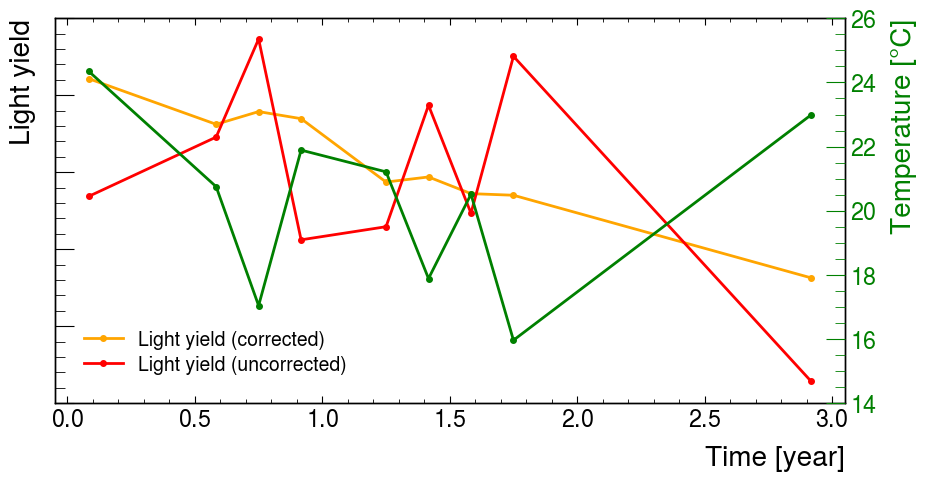

In [13]:
binned_stats = stats.binned_statistic(d["dt_20"], d["PEs_20"],
                                          statistic='mean', bins=18, range=(0,3))
d["dt_binned_20"] = (binned_stats[1][:-1] + binned_stats[1][1:])/2
d["PEs_binned_20"] = binned_stats[0]
binned_stats = stats.binned_statistic(d["dt_20"], d["PEs_uncorrected_20"],
                                          statistic='mean', bins=18, range=(0,3))
d["PEs_uncorrected_binned_20"] = binned_stats[0]
binned_stats = stats.binned_statistic(d["dt_20"], d["temps_20"],
                                          statistic='mean', bins=18, range=(0,3))
d["temps_binned_20"] = binned_stats[0]

valid = ~(np.isnan(d["PEs_binned_20"]) | np.isnan(d["dt_binned_20"]))

fig, ax0 = plt.subplots()
ax1 = ax0.twinx()
ax0.errorbar(d['dt_binned_20'][valid], d["PEs_binned_20"][valid],fmt='.-', color='orange', label='Light yield (corrected)')
ax0.errorbar(d['dt_binned_20'][valid], d["PEs_uncorrected_binned_20"][valid],fmt='.-', color='red', label='Light yield (uncorrected)')
ax1.errorbar(d['dt_binned_20'][valid], d["temps_binned_20"][valid],fmt='.-', color='green')
#ax0.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.083, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1, color='k')

ax0.set_xlabel('Time [year]')

ax0.set_ylabel('Light yield', color='k')
ax1.set_ylabel('Temperature [°C]',color='green')
#ax0.set_title('Module 127 FEB0 Ch20')

ax0.set_xlim((-0.05, 3.05))
ax1.set_xlim((-0.05, 3.05))

ax0.set_yticklabels([])

ax0.legend()

#ax1.set_ylim((min(d["SPEs_{0}".format(chan)]) - 1, max(d["SPEs_{0}".format(chan)]) + 1))
#ax0.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

ax1.tick_params(axis='y', which='both', colors='g')

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.show()

/tmp/ipykernel_13136/2377228883.py:2: RuntimeWarning: invalid value encountered in power
  return A*(1-r/100)**x


low aging 15
low aging 47
low aging 48
low aging 50
low aging 54
low aging 59
low aging 61
Skipping channel 62
Skipping channel 63
low aging 84
Skipping channel 92
Skipping channel 93
Skipping channel 94
Skipping channel 95


/tmp/ipykernel_13136/1121022026.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax0 = plt.subplots()


low aging 114
low aging 116
low aging 119
Skipping channel 122
Skipping channel 123
Skipping channel 124
Skipping channel 125
Skipping channel 126
Skipping channel 127
Is our aging distribution Gaussian?
Gaussian, ShapiroResult(statistic=0.9897238612174988, pvalue=0.5419566035270691)


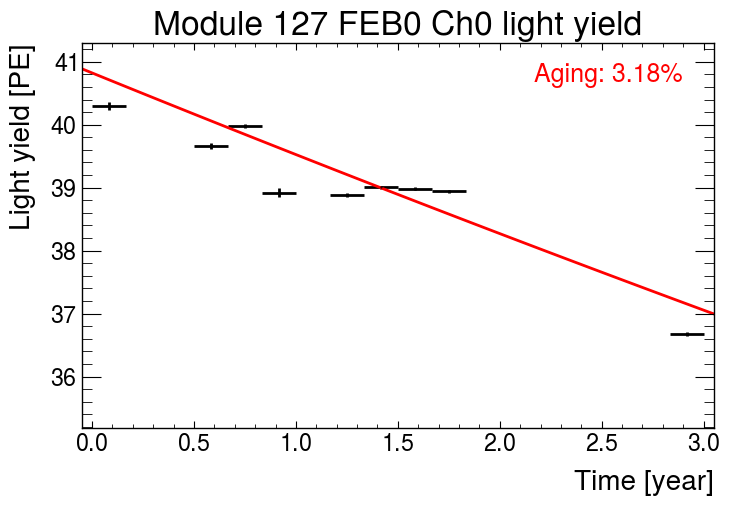

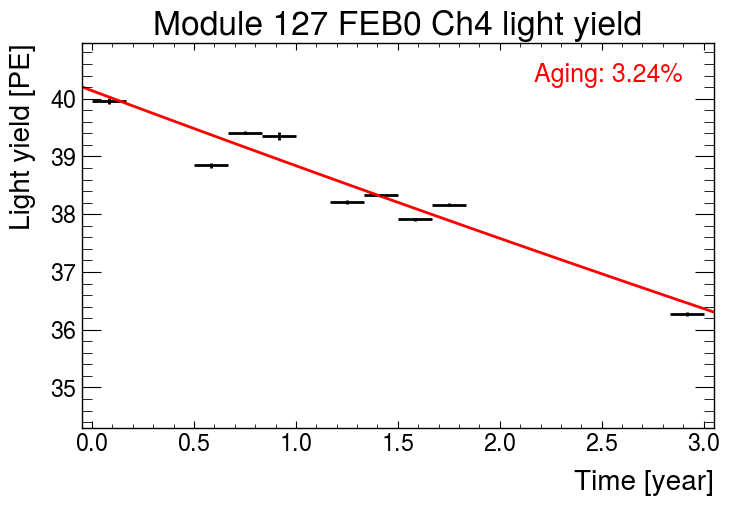

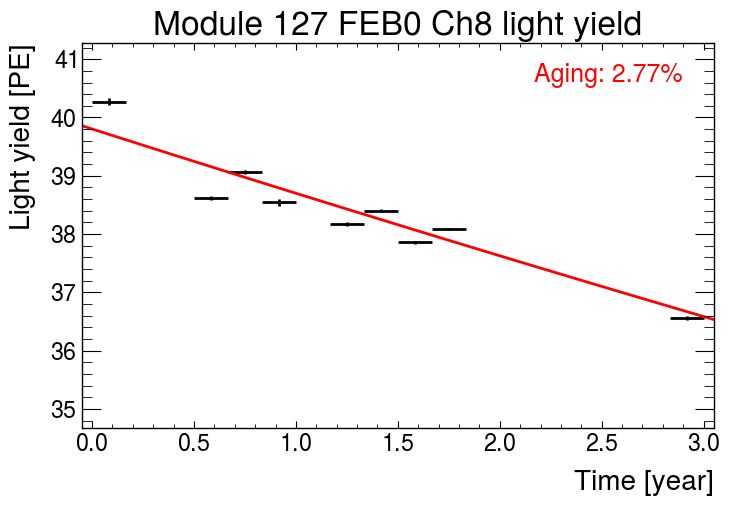

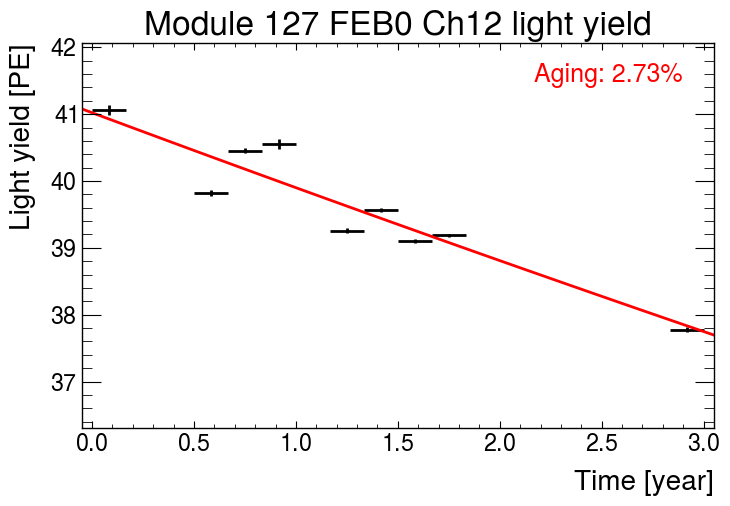

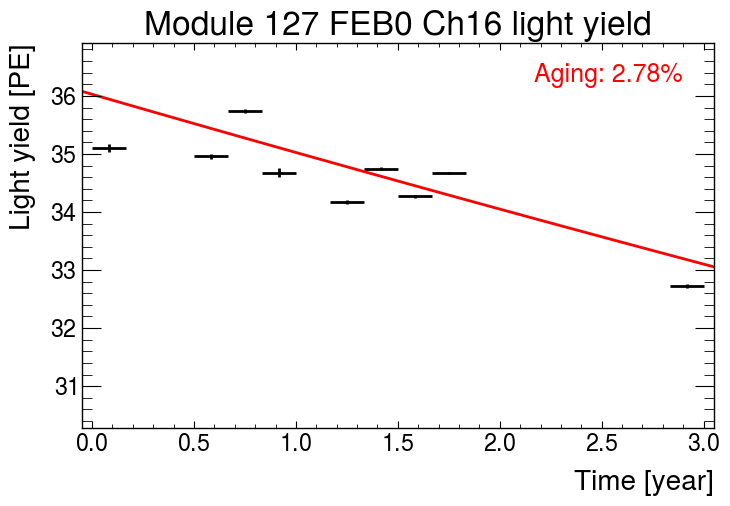

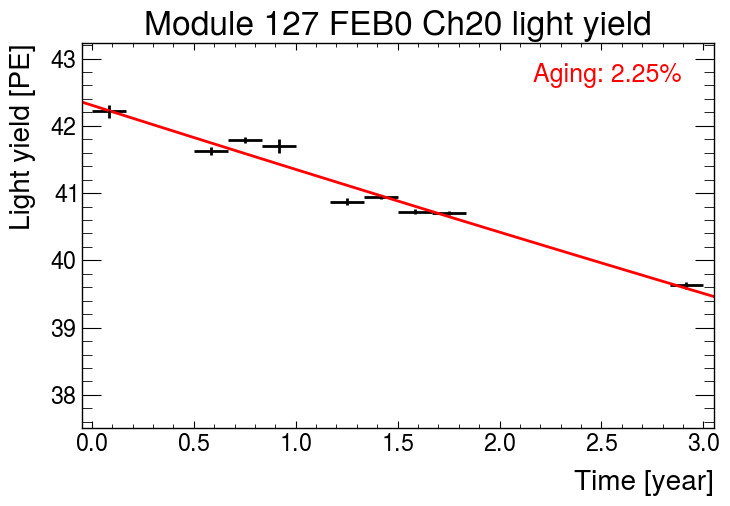

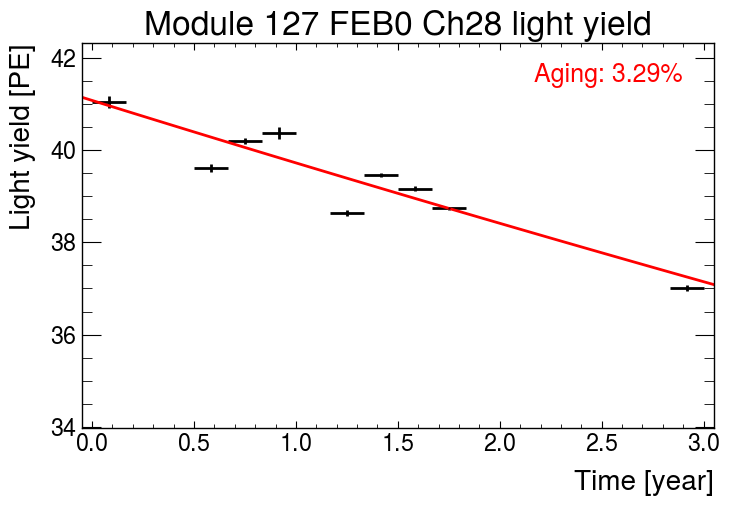

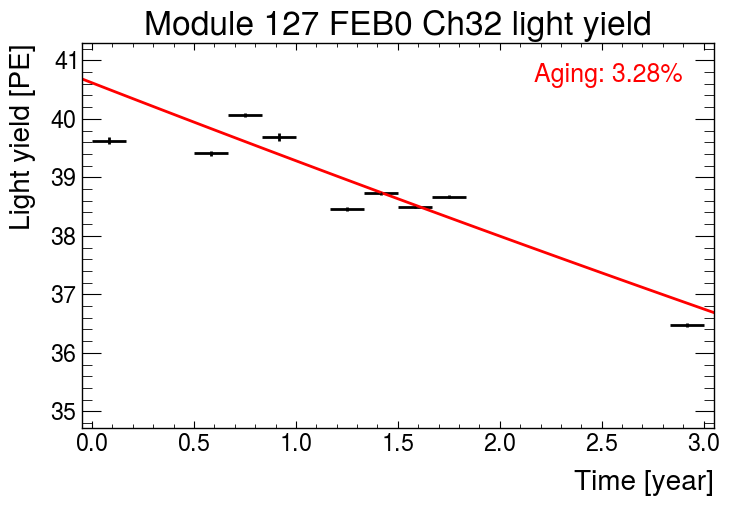

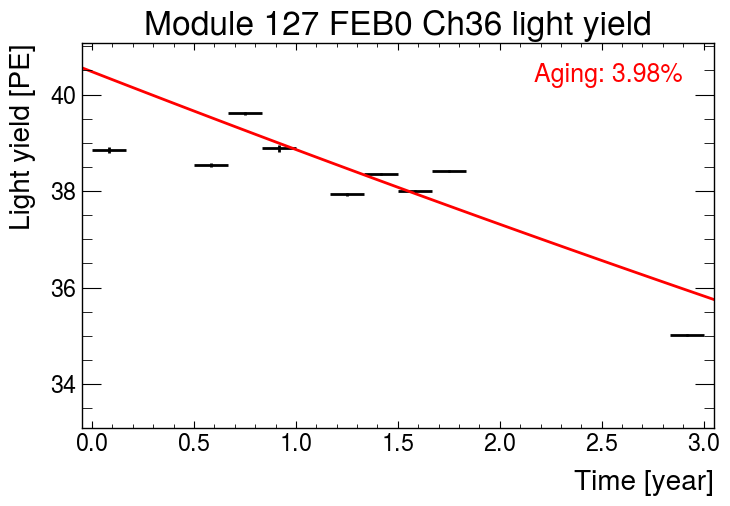

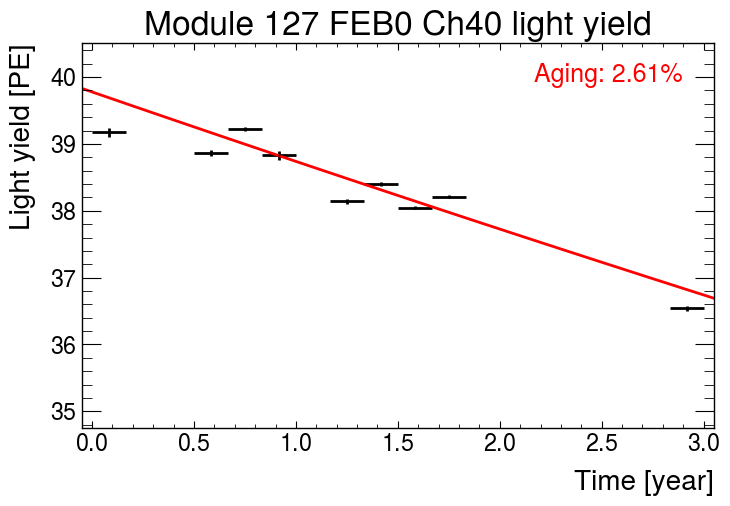

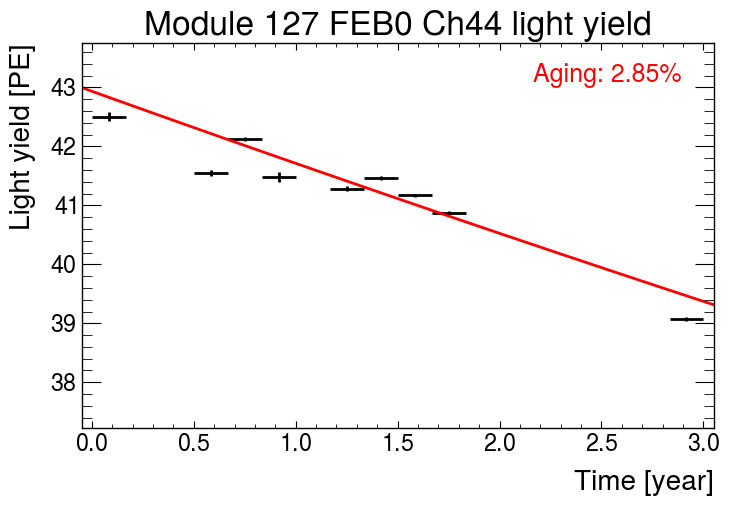

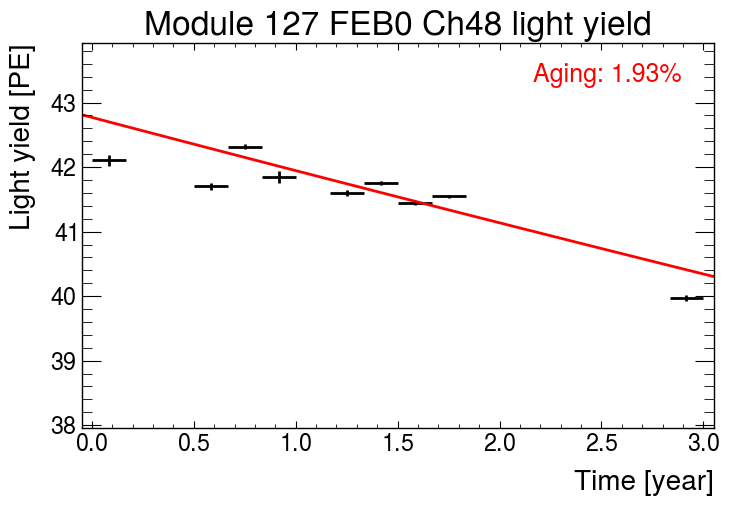

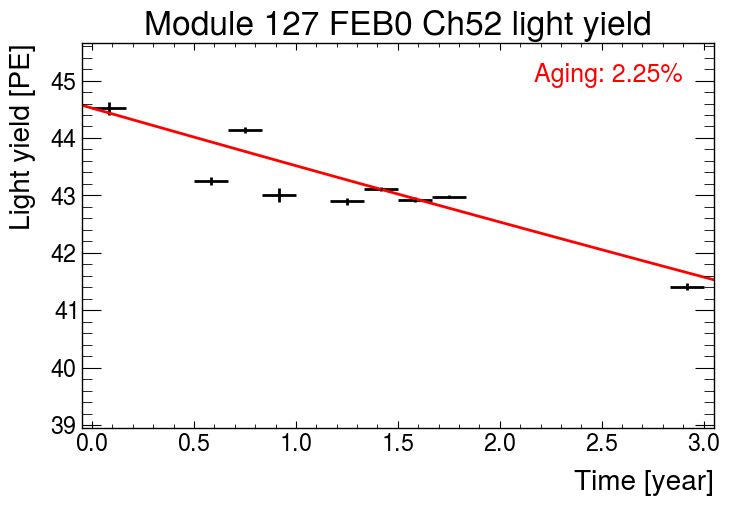

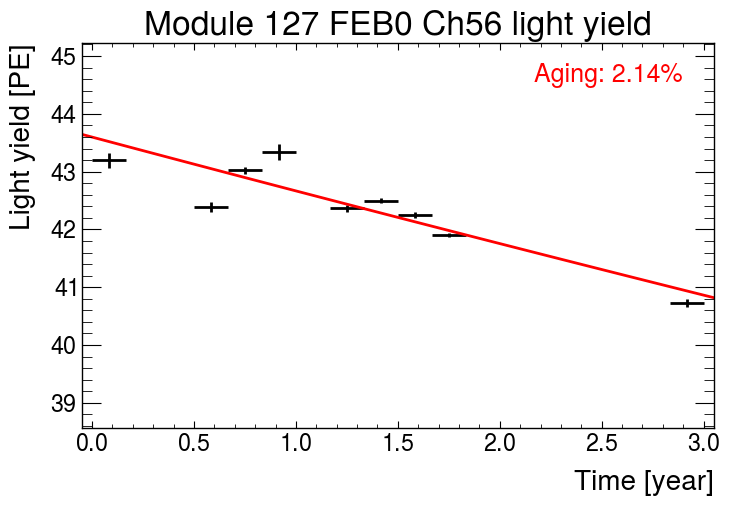

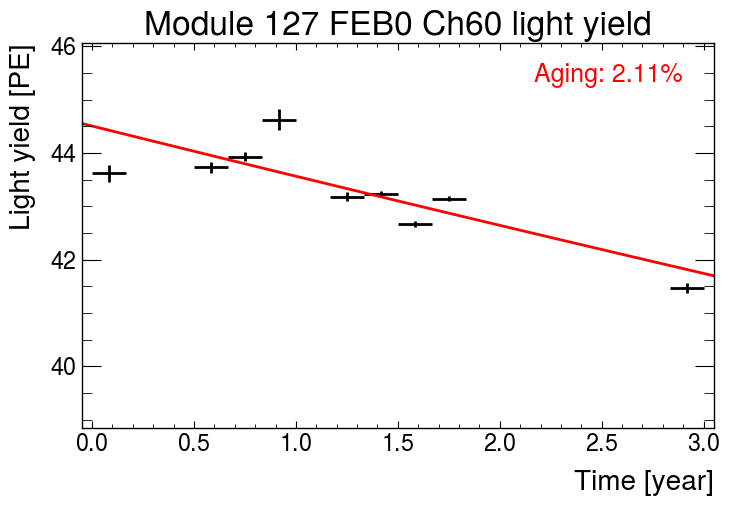

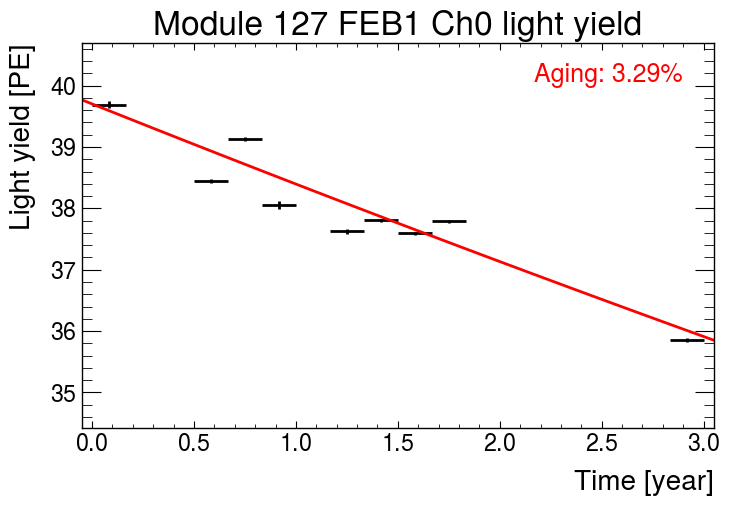

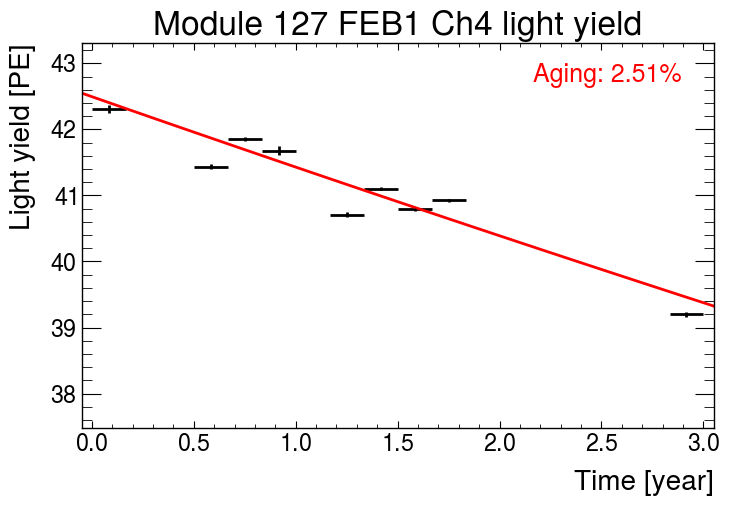

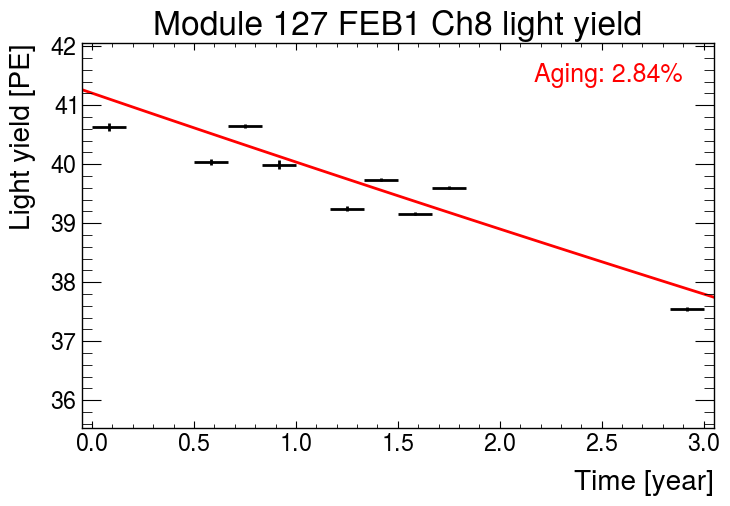

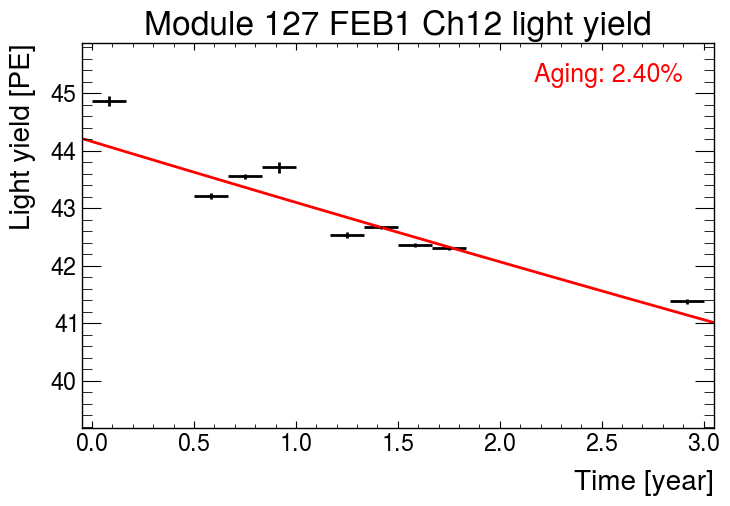

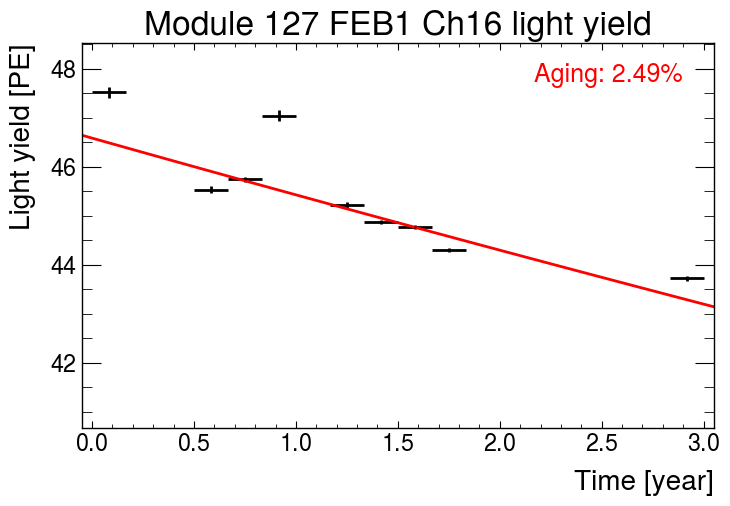

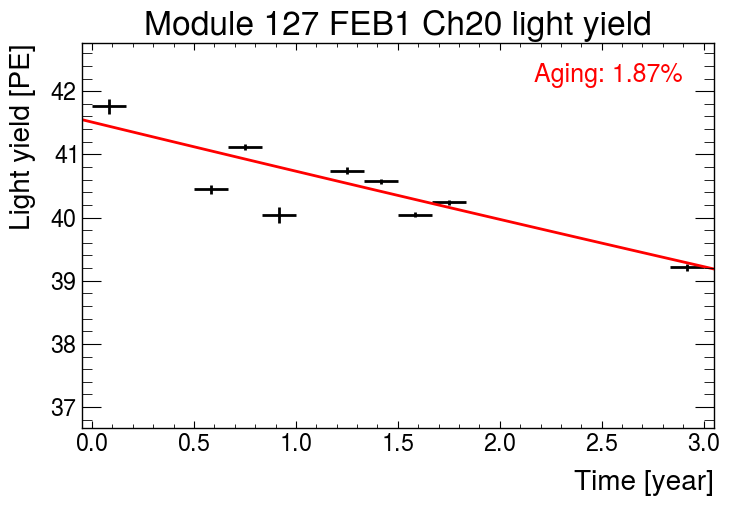

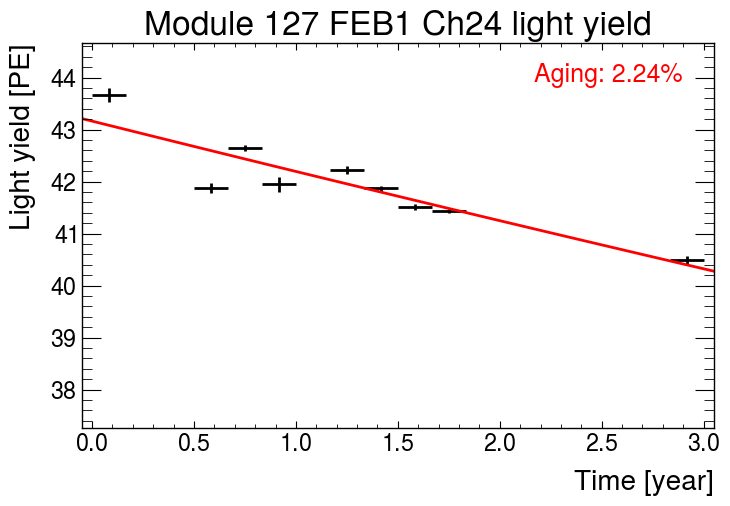

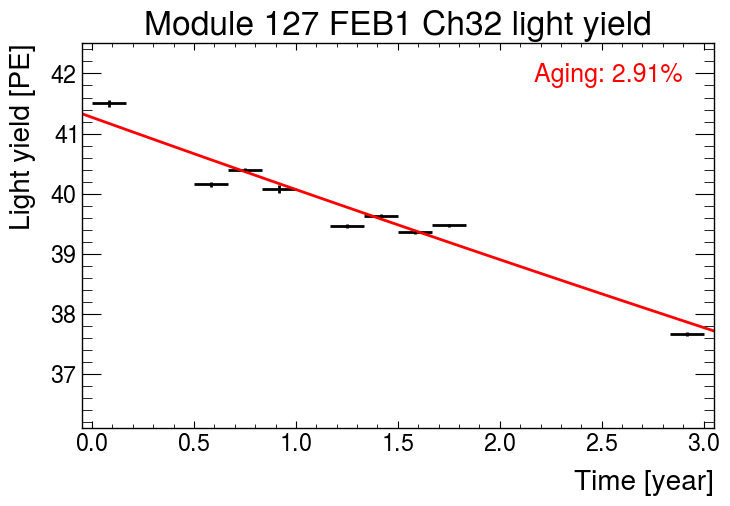

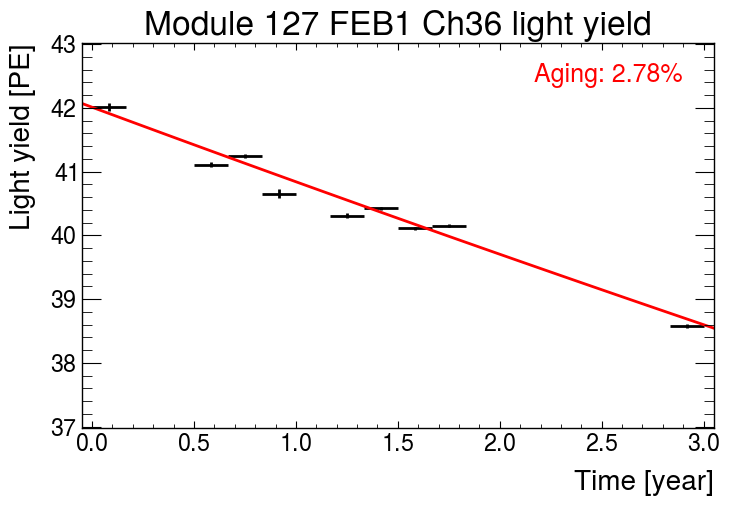

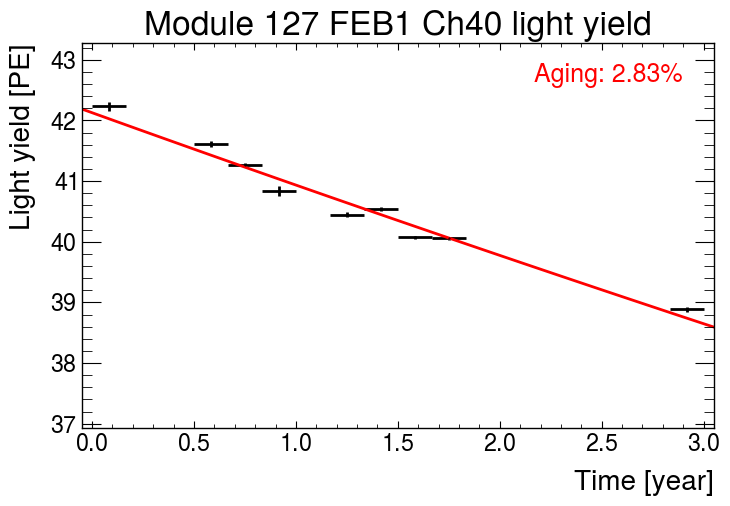

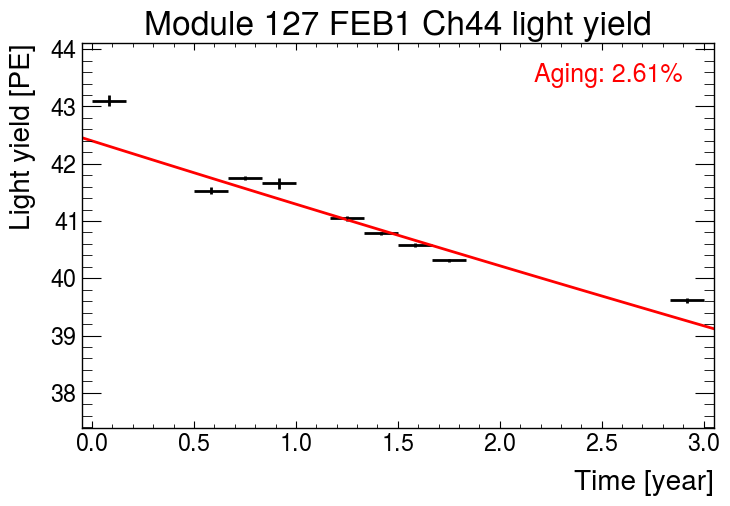

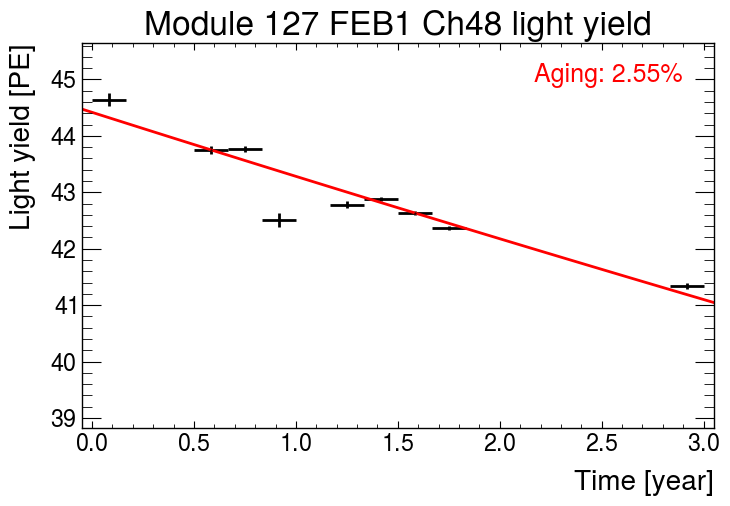

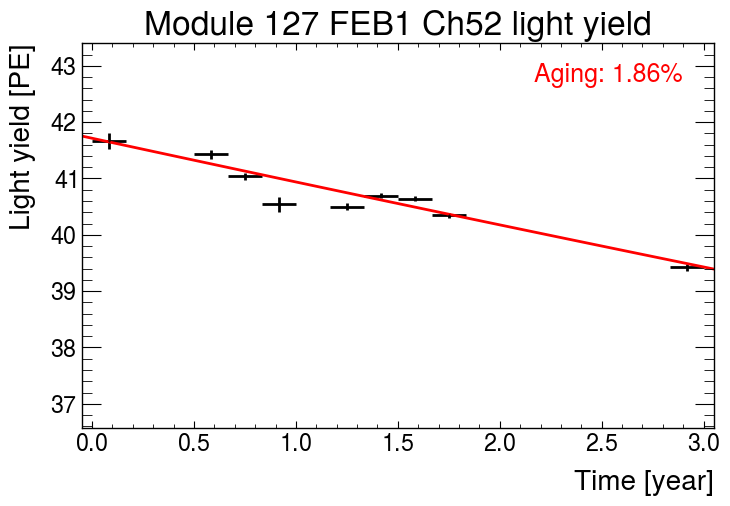

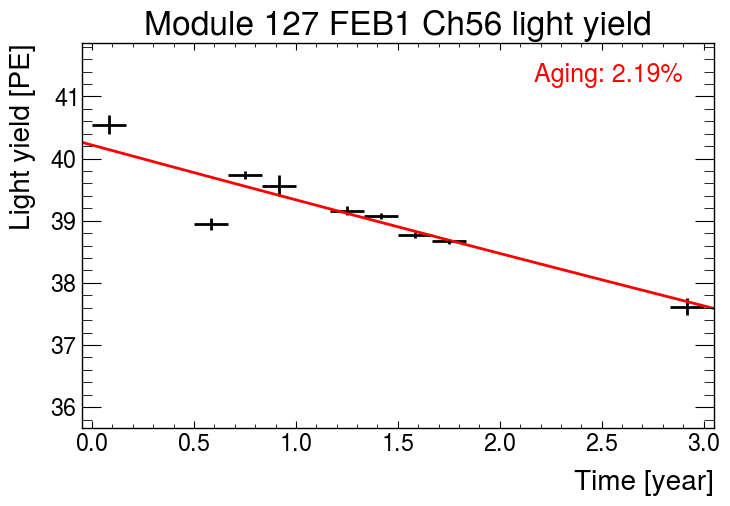

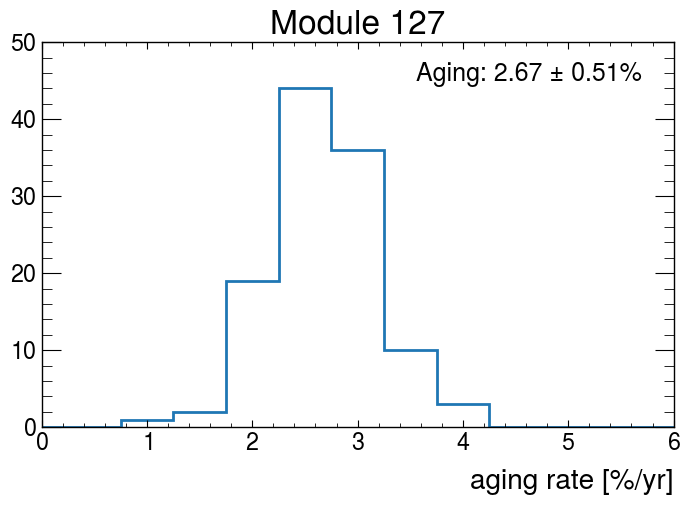

In [6]:
PE_aging = []
lowaging = []
highaging = []

for chan in range(128):
    if chan in badchannels:
        continue
        
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
    d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2
    d["PEs_binned_{0}".format(chan)] = binned_stats[0]
    
    d["PEs_sigma_binned_{0}".format(chan)] = []
    for i in range(len(d["PEs_binned_{0}".format(chan)])):
        error = 0
        n = 0
        for j in range(len(d["PEs_sigma_{0}".format(chan)])):
            if d["dt_{0}".format(chan)][j] >= binned_stats[1][i] and d["dt_{0}".format(chan)][j] <= binned_stats[1][i+1]:
                error += (d["PEs_sigma_{0}".format(chan)][j])**2
                n += 1
        if n > 0:
            error = np.sqrt(error)/n
        d["PEs_sigma_binned_{0}".format(chan)].append(error)
    d["PEs_sigma_binned_{0}".format(chan)] = np.array(d["PEs_sigma_binned_{0}".format(chan)])
    
    valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]))
    
    if d["dt_binned_{0}".format(chan)][valid][-1] < 2:
        badchannels.append(chan)
        print("Skipping channel {0}".format(chan))
        continue
    
    popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                           sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
    #print(popt)
    PE_aging.append(popt[1])
    d["aging_{0}".format(chan)] = popt[1]
    d["initial_{0}".format(chan)] = popt[0]
    
    chi2 = 0
    for i in range(len(d["dt_binned_{0}".format(chan)][valid])):
        chi2 += ((d["PEs_binned_{0}".format(chan)][valid][i] - aging(d["dt_binned_{0}".format(chan)][valid][i], popt[0], popt[1]))/d["PEs_sigma_binned_{0}".format(chan)][valid][i])**2
    d["chi2_binned_{0}".format(chan)] = chi2
    d["chi2NDF_binned_{0}".format(chan)] = chi2/2

    if popt[1] < 2:
        print("low aging", chan)
        lowaging.append(chan)
    if popt[1] > 5:
        print("high aging", chan)
        highaging.append(chan)

    if chan%4 == 0:
        fig, ax0 = plt.subplots()
        ax0.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.083, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1, color='k')
        ax0.plot(np.linspace(-0.1, 3.1, 100), aging(np.linspace(-0.1, 3.1, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')

        ax0.set_ylabel('Light yield [PE]')
        ax0.set_title('Module 127 FEB{0} Ch{1} light yield'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 3.05))

        ax0.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

        ax0.text(.95, .95, 'Aging: {0:.2f}%'.format(round(popt[1], 2)), fontsize=18, color='r', ha='right', va='top', transform=ax0.transAxes)
        #ax0.text(.95, .85, 'Chi2: {0:.2f}'.format(d["chi2_binned_{0}".format(chan)]), fontsize=18, ha='right', va='top', transform=ax0.transAxes)

        
        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(8)
        fig.show()

meanAging = np.mean(PE_aging)
stdAging = np.std(PE_aging)

print("Is our aging distribution Gaussian?")

if stats.shapiro(PE_aging)[1]<0.05:
    print("Not Gaussian,", stats.shapiro(PE_aging))
else:
    print("Gaussian,", stats.shapiro(PE_aging))
        
fig, ax0 = plt.subplots()
ax0.hist(PE_aging, bins = np.linspace(-0.75, 10.25, 23), histtype='step', linewidth=2)

ax0.set_title('Module 127')
ax0.set_xlabel('aging rate [%/yr]')

ax0.set_xlim((0,6))

ax0.text(.95, .95, 'Aging: {0:.2f} ± {1:.2f}%'.format(round(meanAging, 2), round(stdAging, 2)), fontsize=18, ha='right', va='top', transform=ax0.transAxes)

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.show()

Is our aging distribution Gaussian?
Gaussian, ShapiroResult(statistic=0.9831962585449219, pvalue=0.6113089323043823)


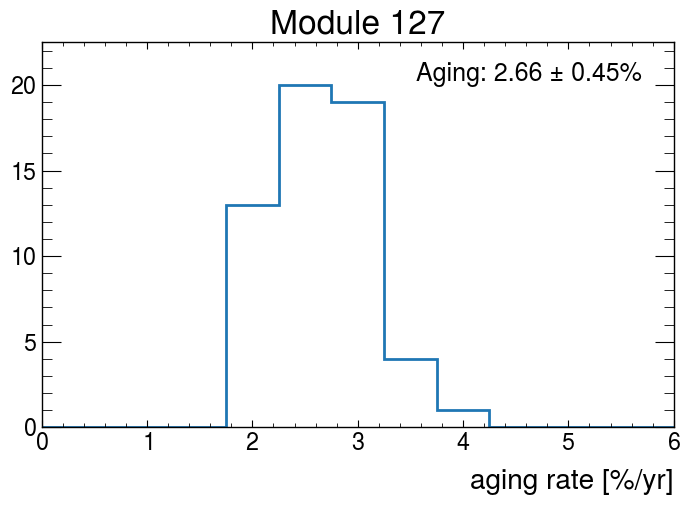

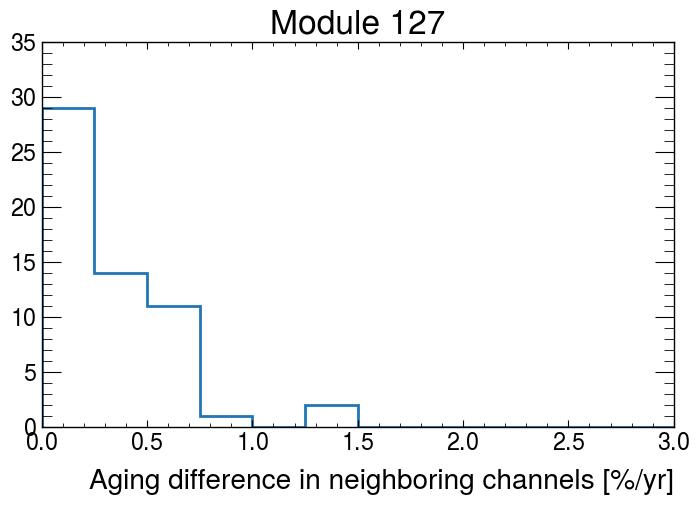

In [7]:
PE_aging_avg = []
PE_aging_difference = []

for dicounter in range(64):
    if 2*dicounter in badchannels:
        continue
    if 2*dicounter+1 in badchannels:
        continue
        
    PE_aging_avg.append((d["aging_{0}".format(2*dicounter)] + d["aging_{0}".format(2*dicounter+1)])/2)
    PE_aging_difference.append(abs(d["aging_{0}".format(2*dicounter)] - d["aging_{0}".format(2*dicounter+1)]))
    

meanAging = np.mean(PE_aging_avg)
stdAging = np.std(PE_aging_avg)

print("Is our aging distribution Gaussian?")

if stats.shapiro(PE_aging)[1]<0.05:
    print("Not Gaussian,", stats.shapiro(PE_aging_avg))
else:
    print("Gaussian,", stats.shapiro(PE_aging_avg))
        
fig, ax0 = plt.subplots()
ax0.hist(PE_aging_avg, bins = np.linspace(-0.75, 10.25, 23), histtype='step', linewidth=2)

ax0.set_title('Module 127')
ax0.set_xlabel('aging rate [%/yr]')

ax0.set_xlim((0,6))

ax0.text(.95, .95, 'Aging: {0:.2f} ± {1:.2f}%'.format(round(meanAging, 2), round(stdAging, 2)), fontsize=18, ha='right', va='top', transform=ax0.transAxes)

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.show()

fig, ax0 = plt.subplots()
ax0.hist(PE_aging_difference, bins = np.linspace(-0.75, 10.25, 45), histtype='step', linewidth=2)

ax0.set_title('Module 127')
ax0.set_xlabel('Aging difference in neighboring channels [%/yr]')

ax0.set_xlim((0,3))

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.show()

In [ ]:
fig, ax = plt.subplots()

for chan in range(128):
    if chan in badchannels:
        continue
    if chan < 64:
        ax.errorbar(chan, d["aging_{0}".format(chan)], fmt='.', color='blue')
    else:
        ax.errorbar(chan-64, d["aging_{0}".format(chan)], fmt='.', color='orange')

ax.set_ylabel('Aging rate [%/yr]')
ax.set_xlabel('Channel')

ax.text(.05, .13, 'FEB 0', fontsize=15, color='orange', ha='left', va='bottom', transform=ax.transAxes)
ax.text(.05, .05, 'FEB 1', fontsize=15, color='blue', ha='left', va='bottom', transform=ax.transAxes)

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.show()

/tmp/ipykernel_1931/2377228883.py:2: RuntimeWarning: invalid value encountered in power
  return A*(1-r/100)**x
/tmp/ipykernel_1931/4170232733.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax0 = plt.subplots()


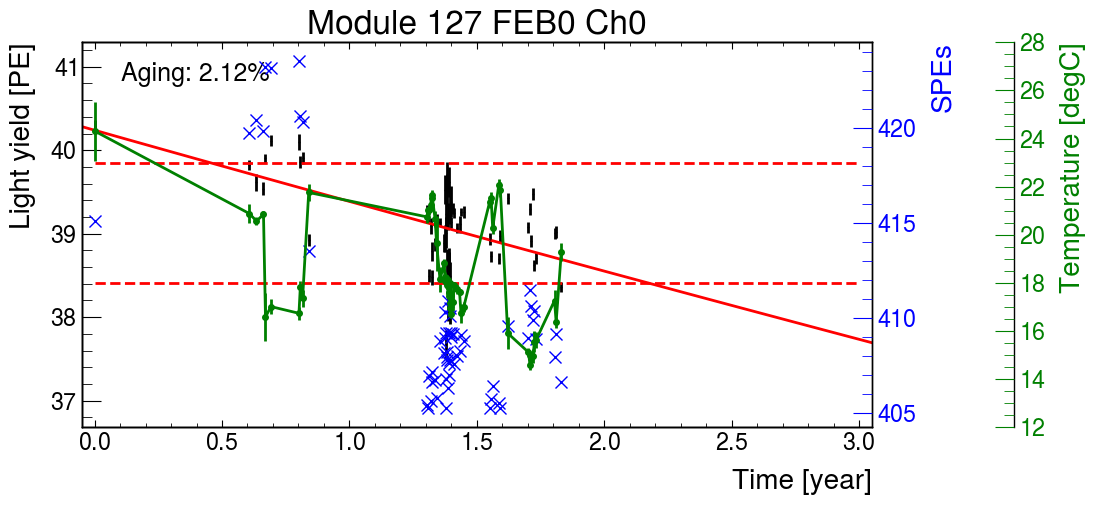

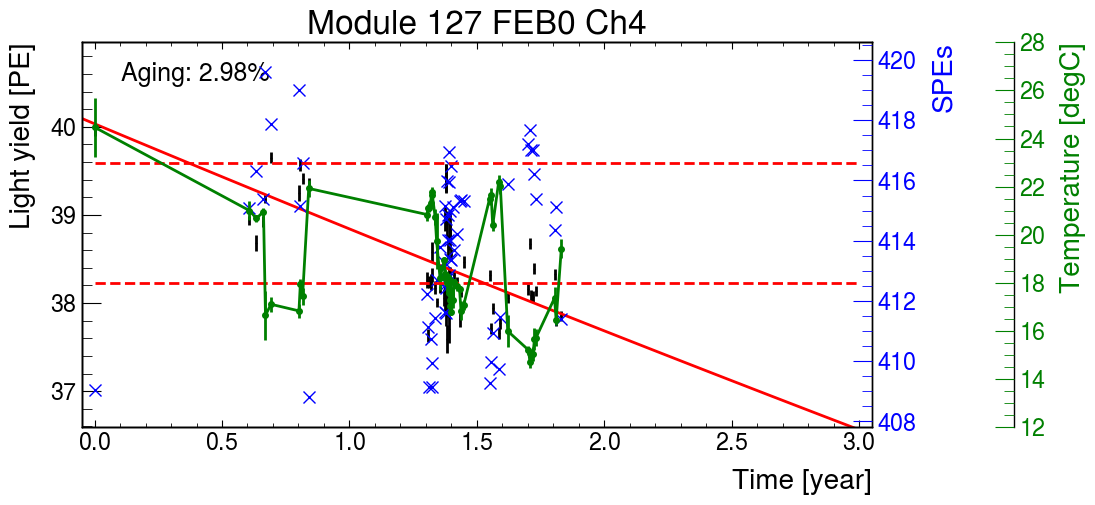

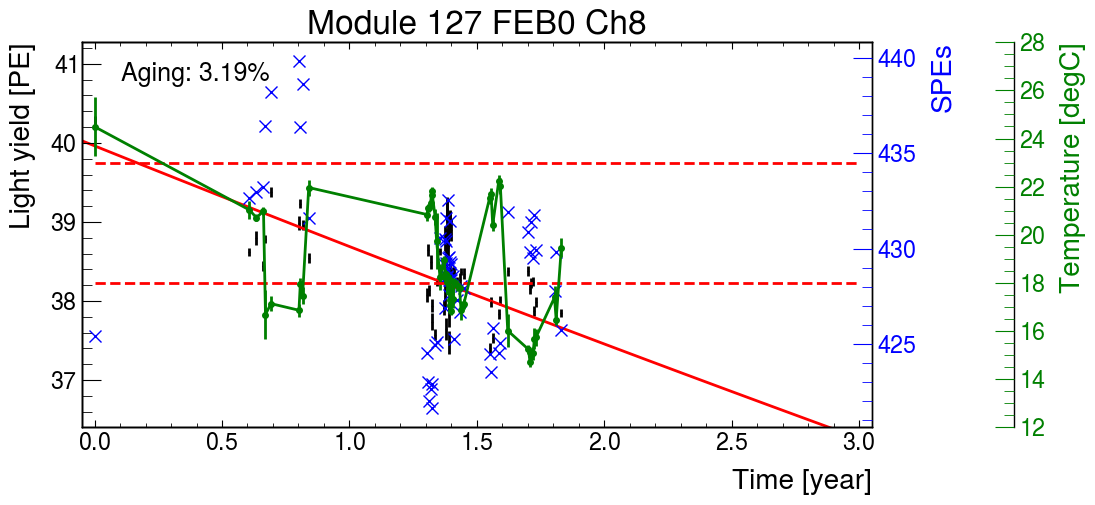

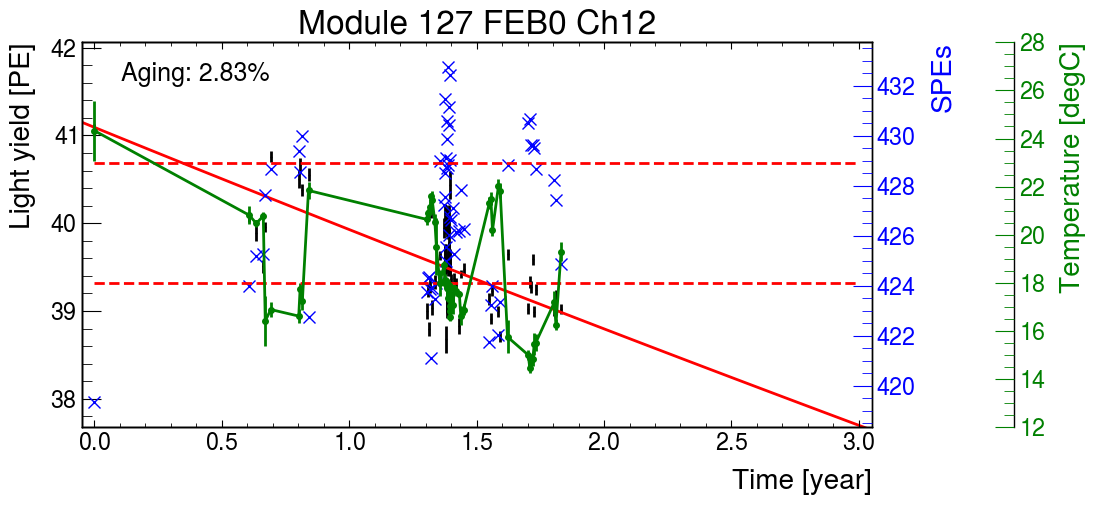

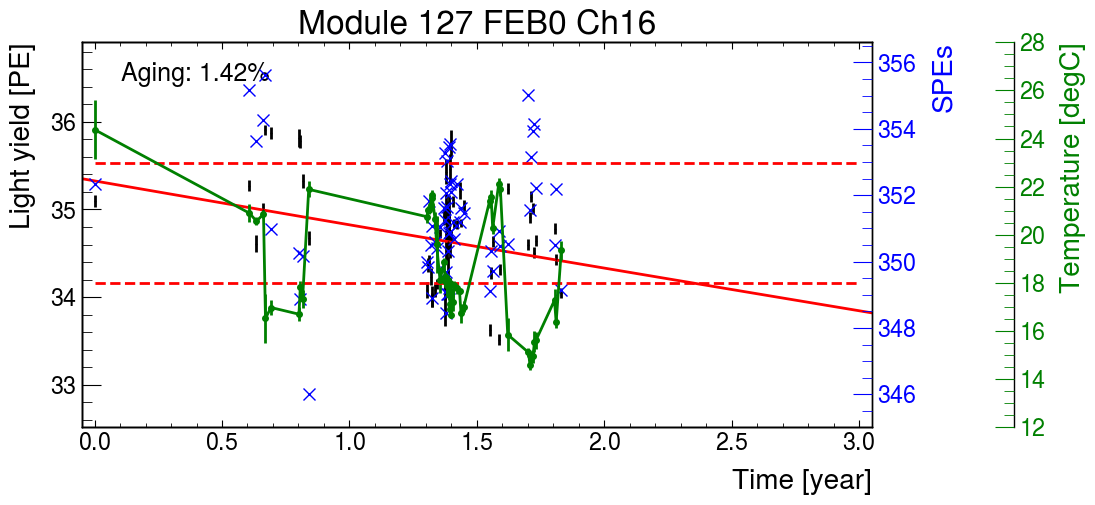

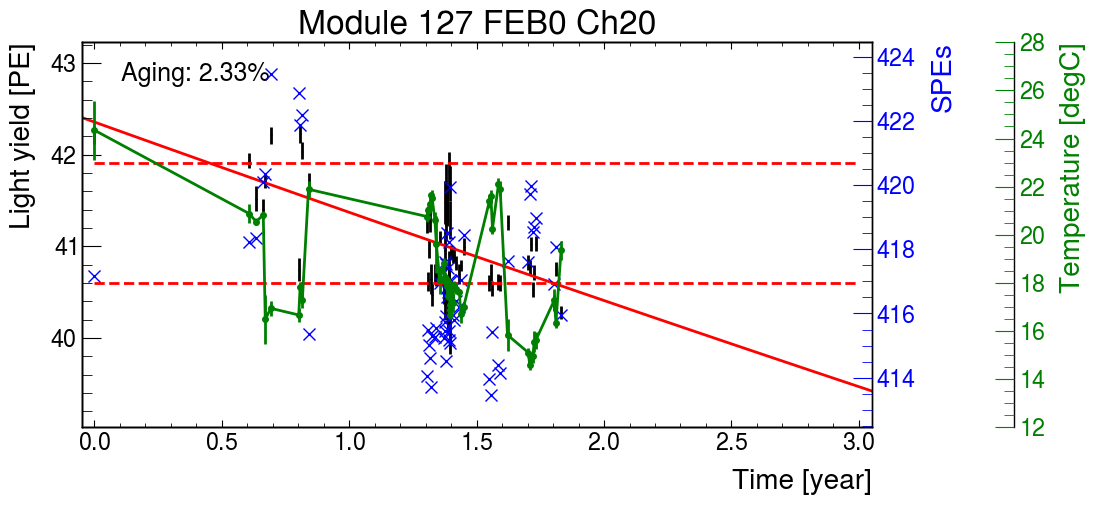

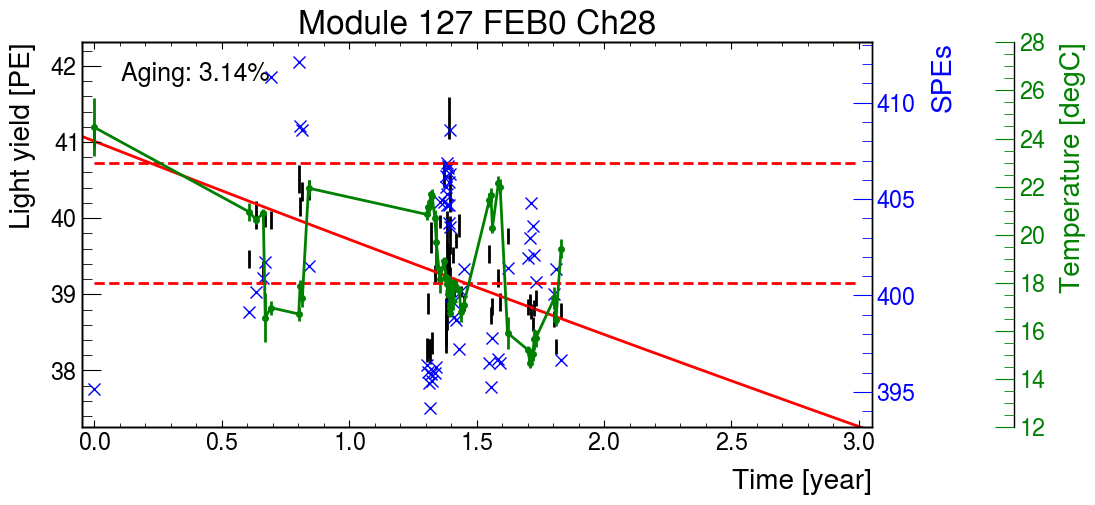

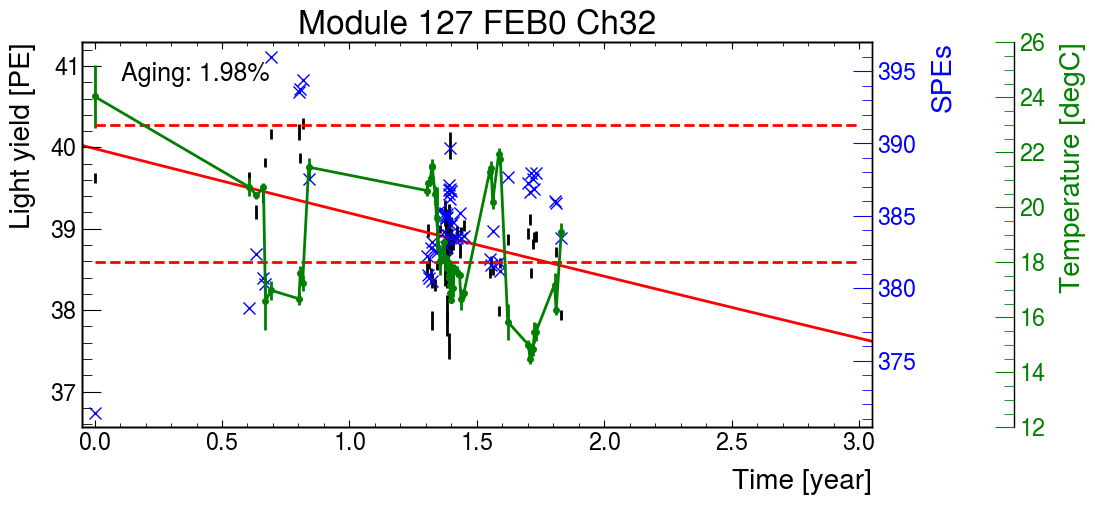

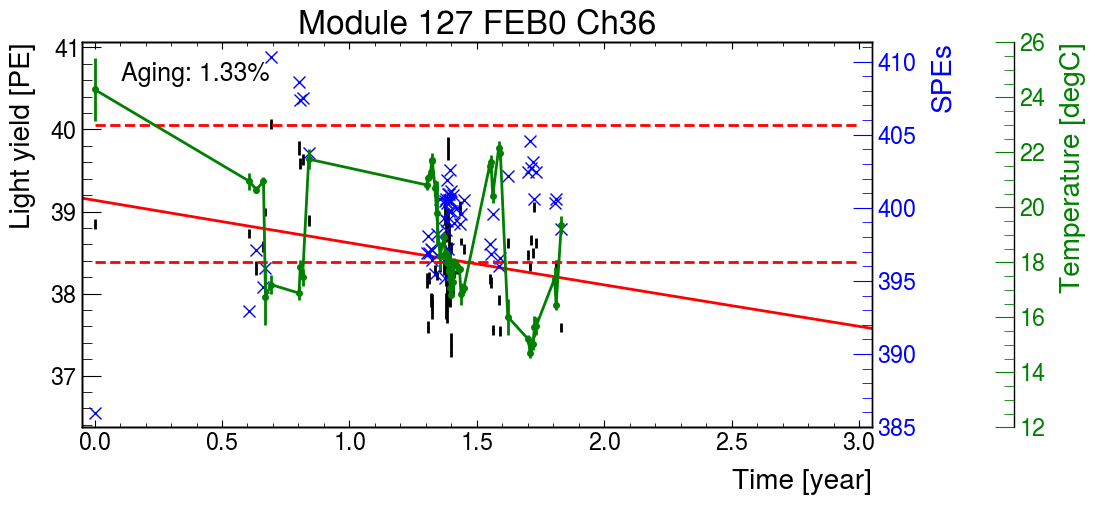

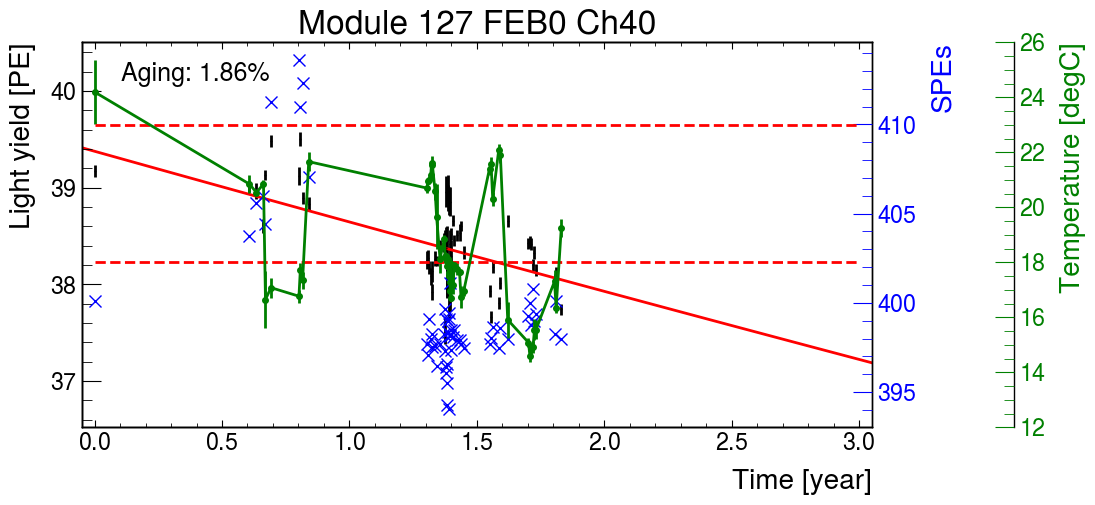

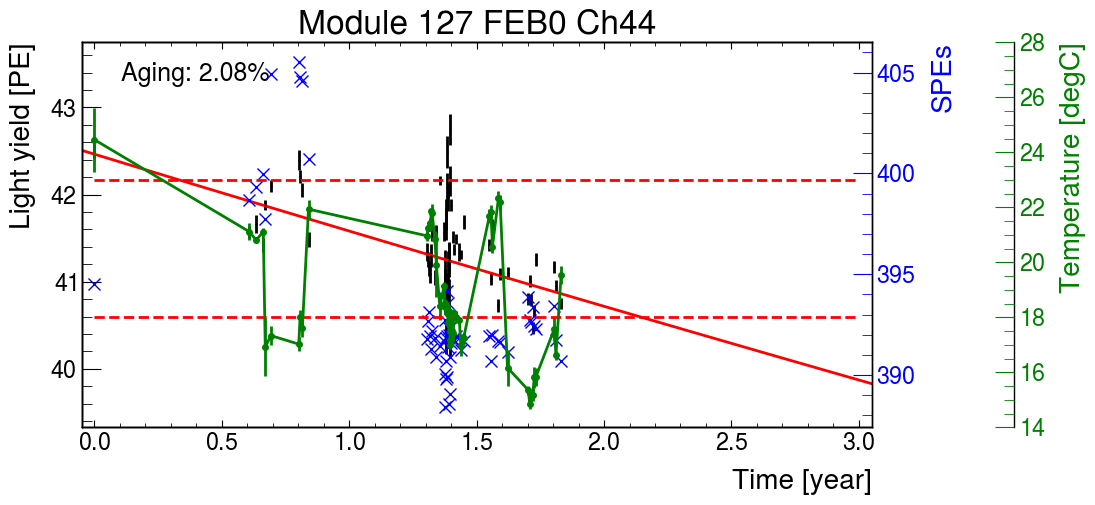

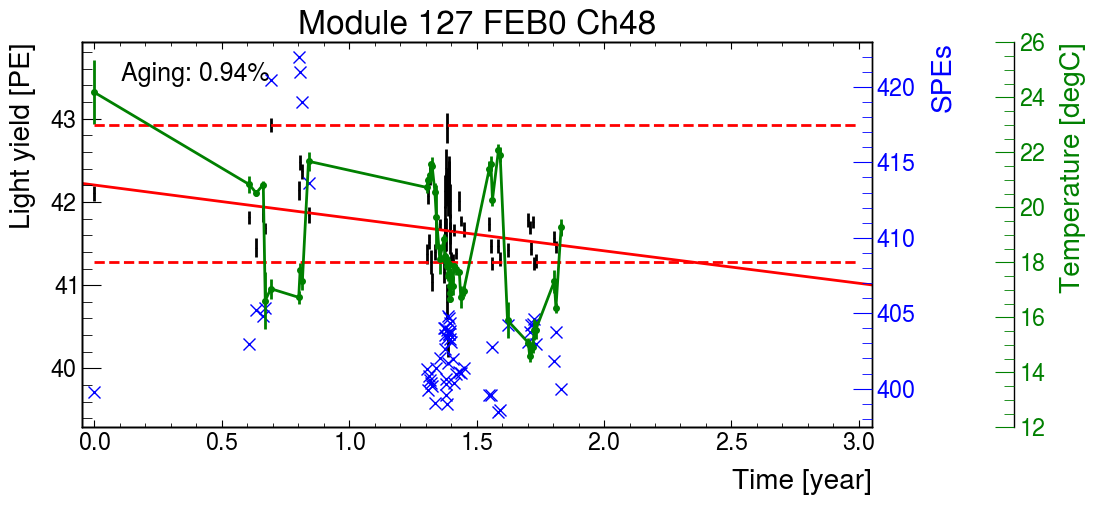

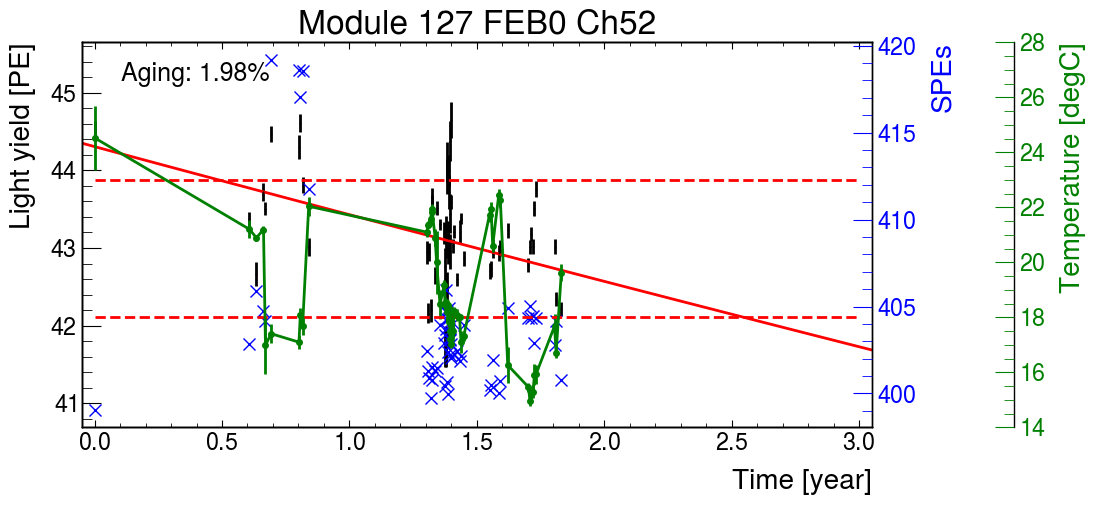

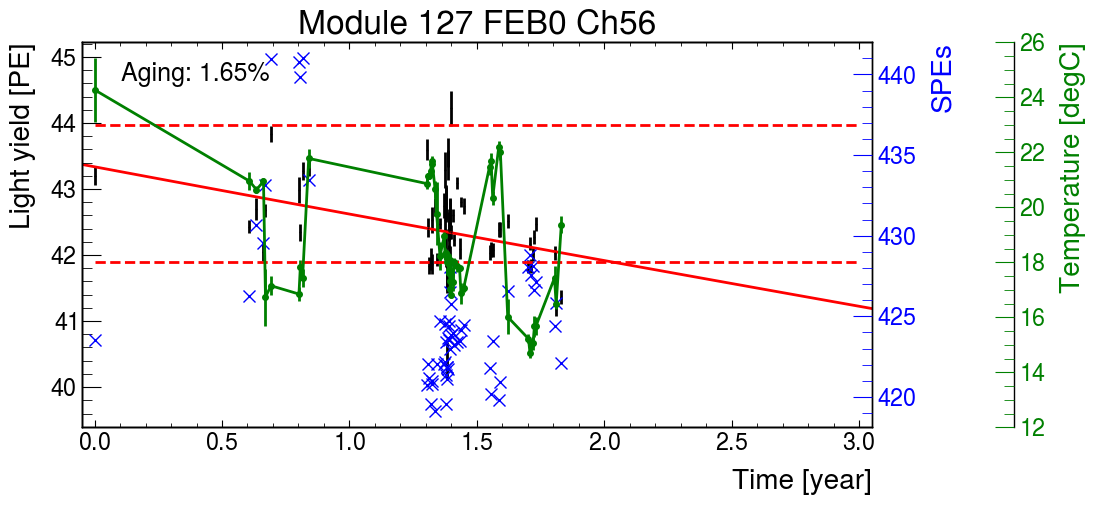

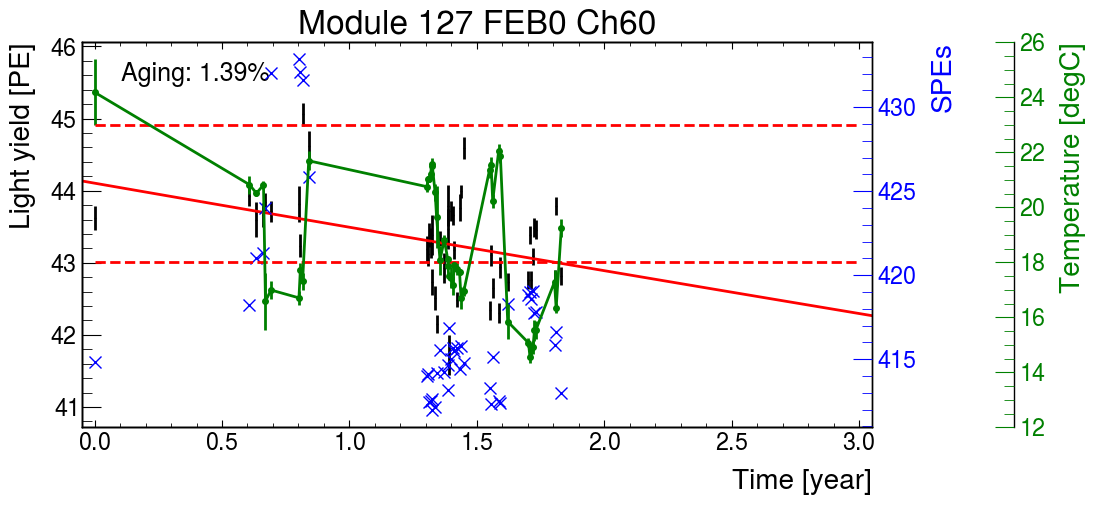

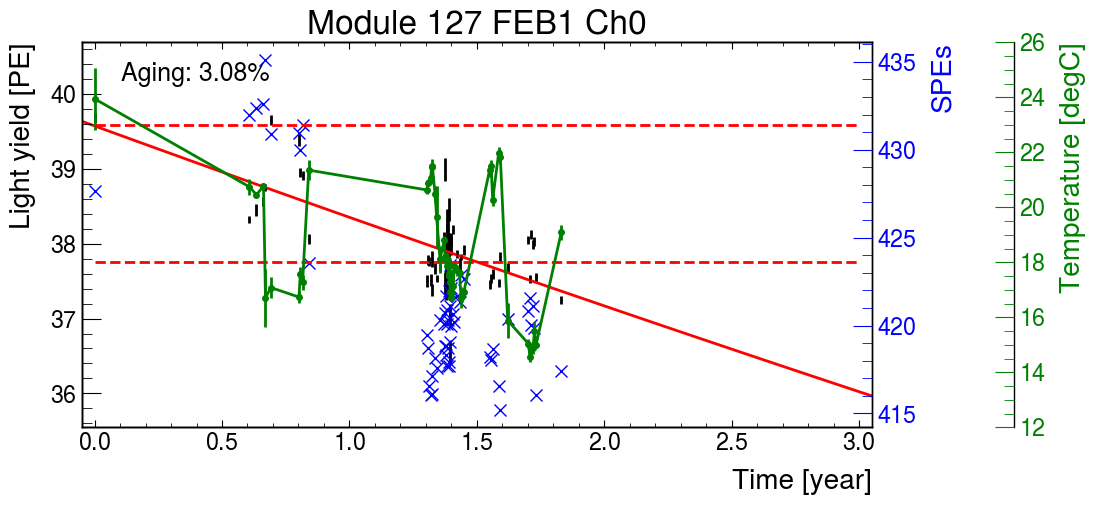

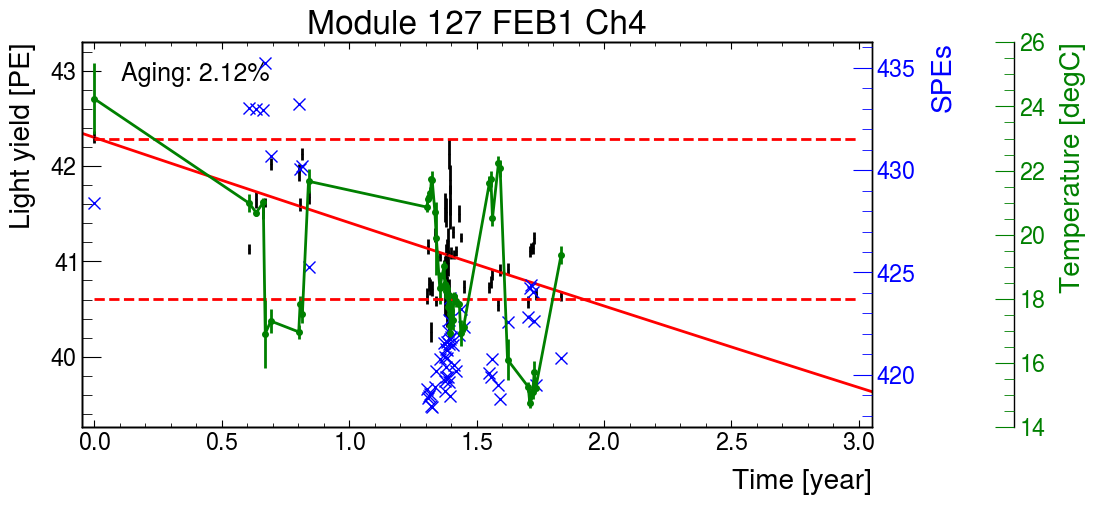

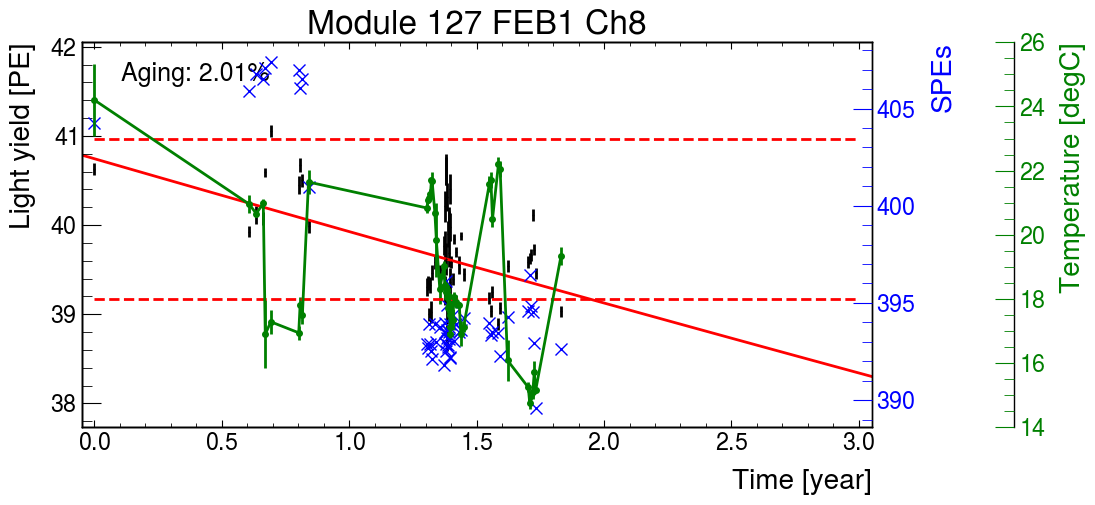

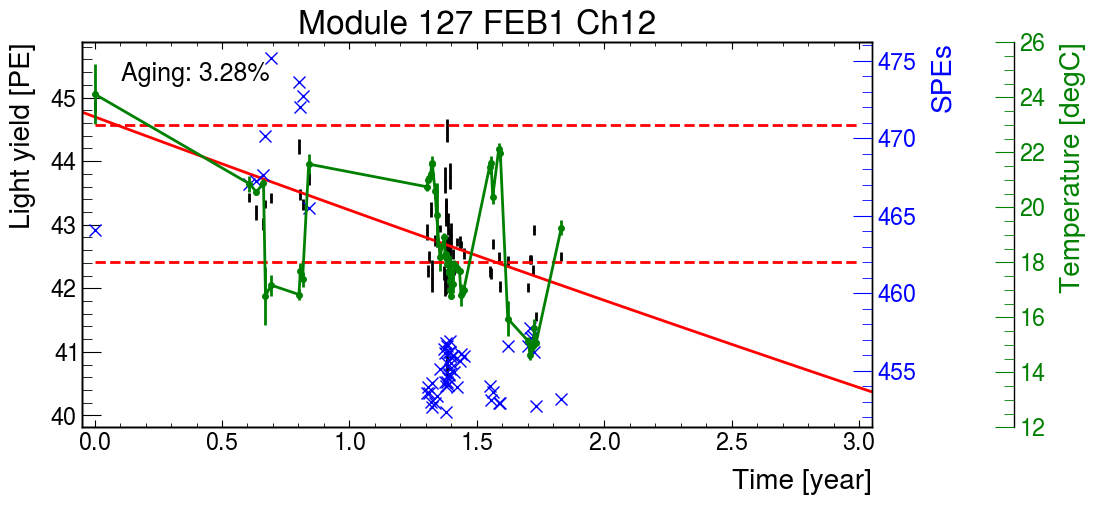

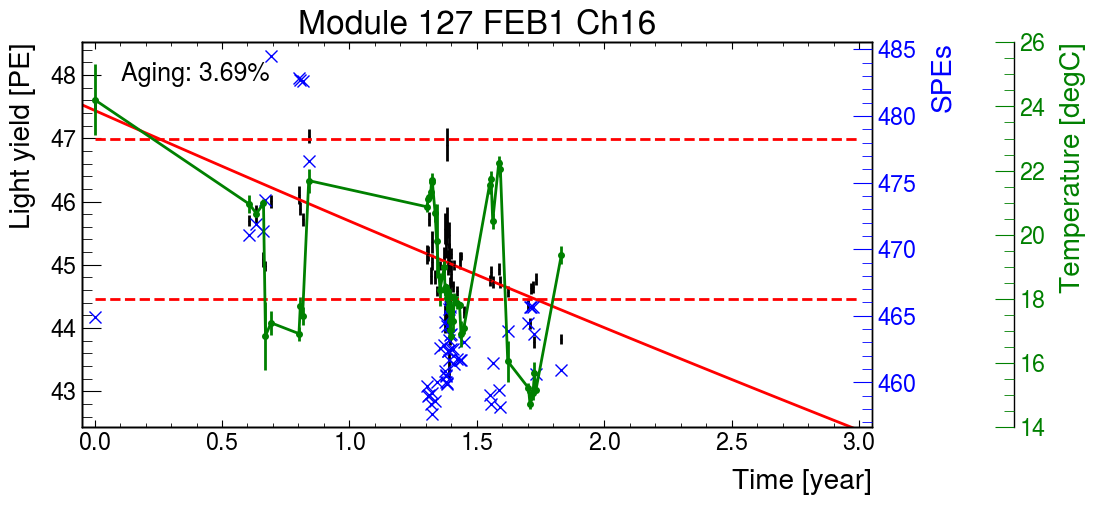

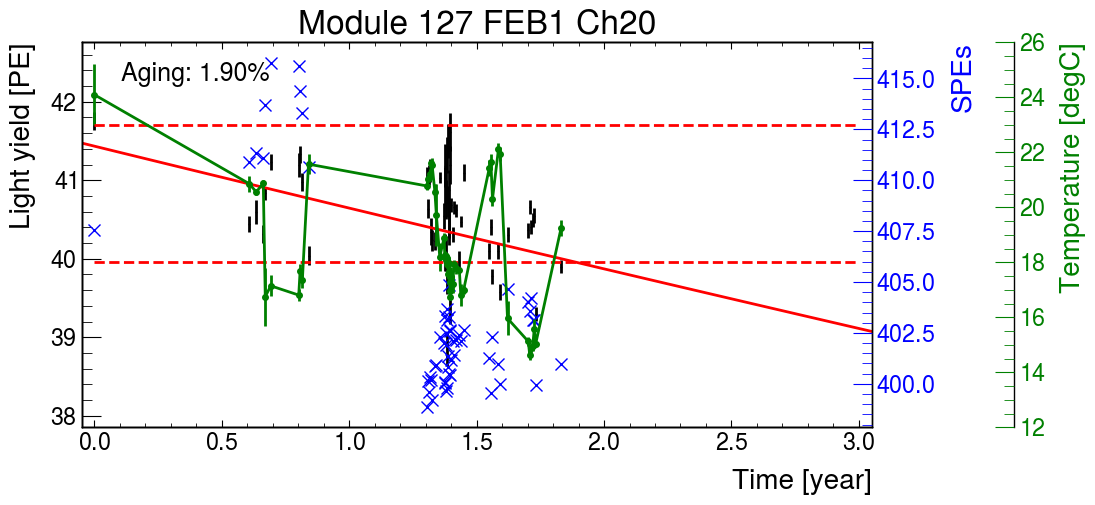

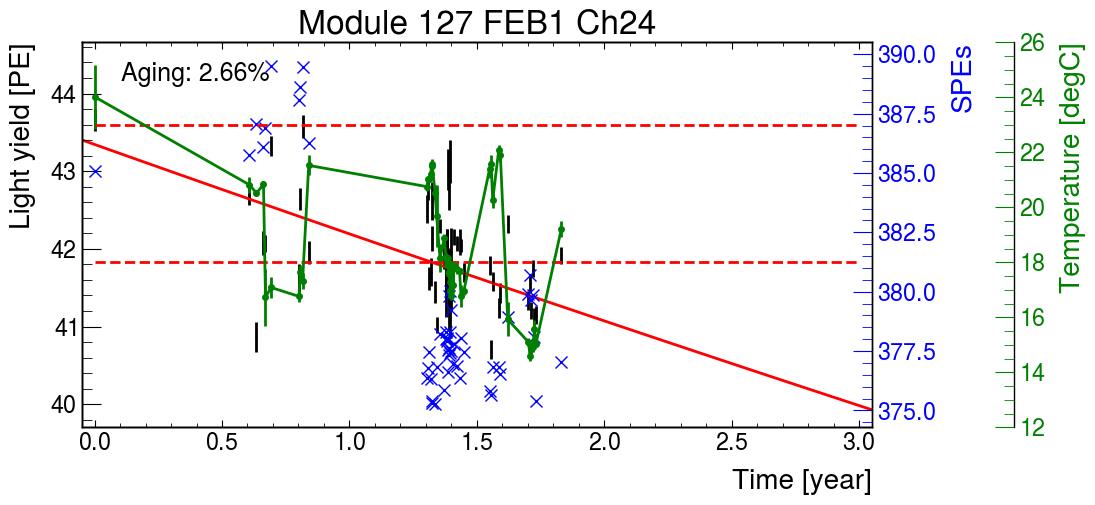

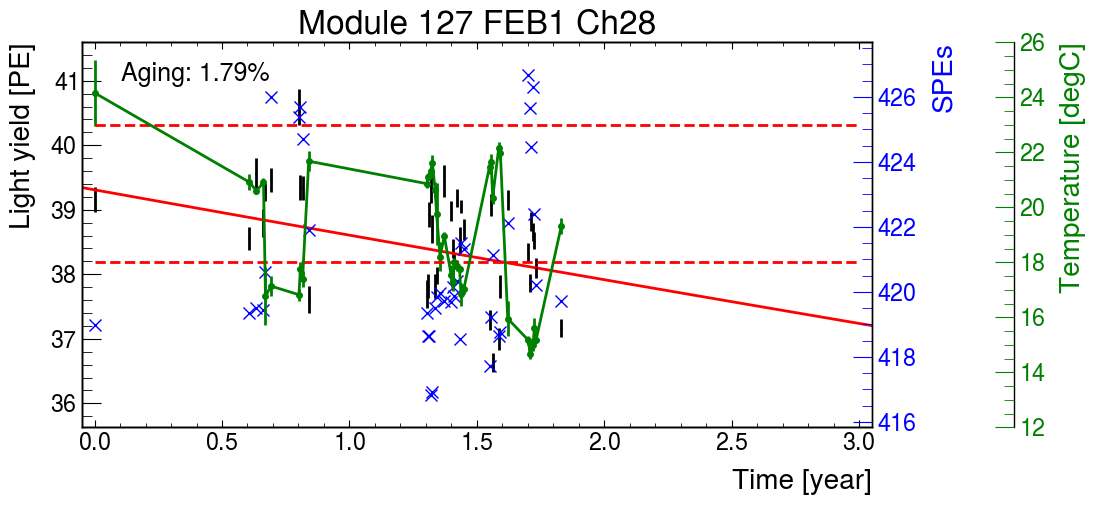

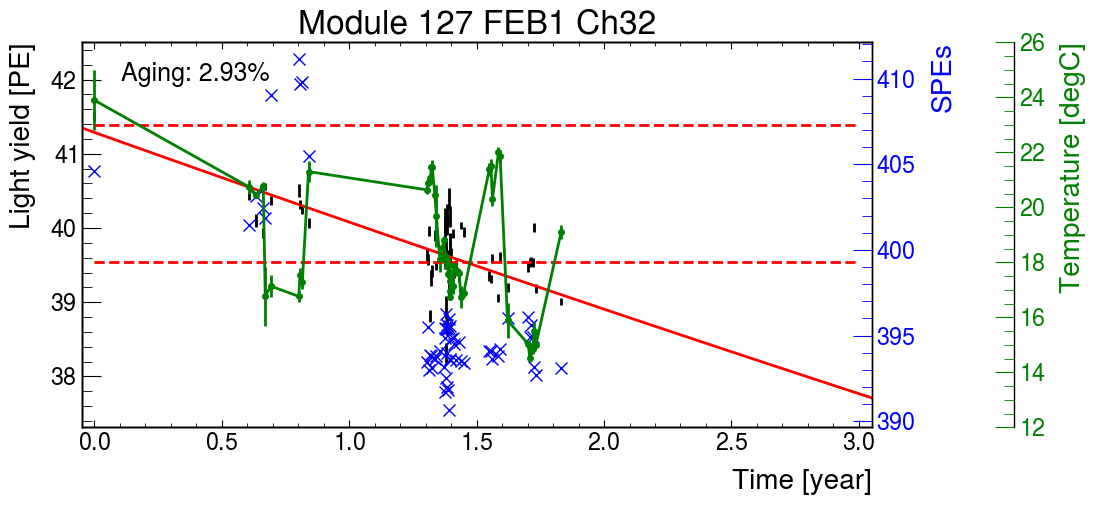

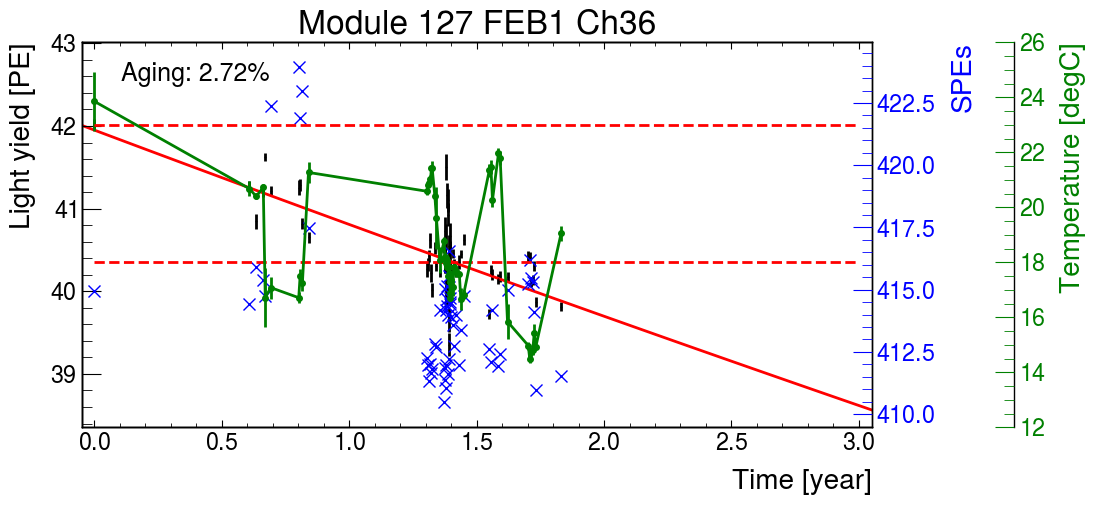

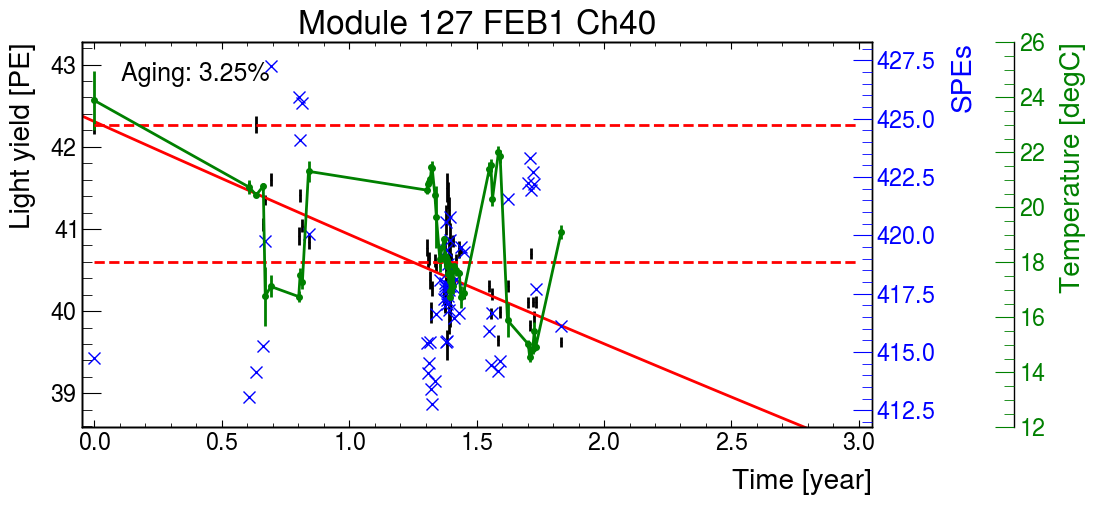

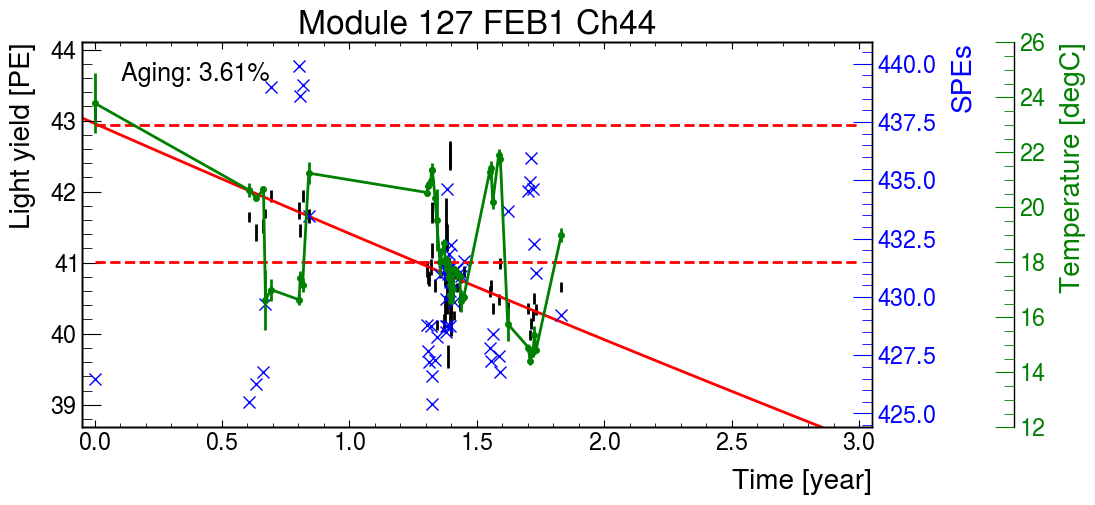

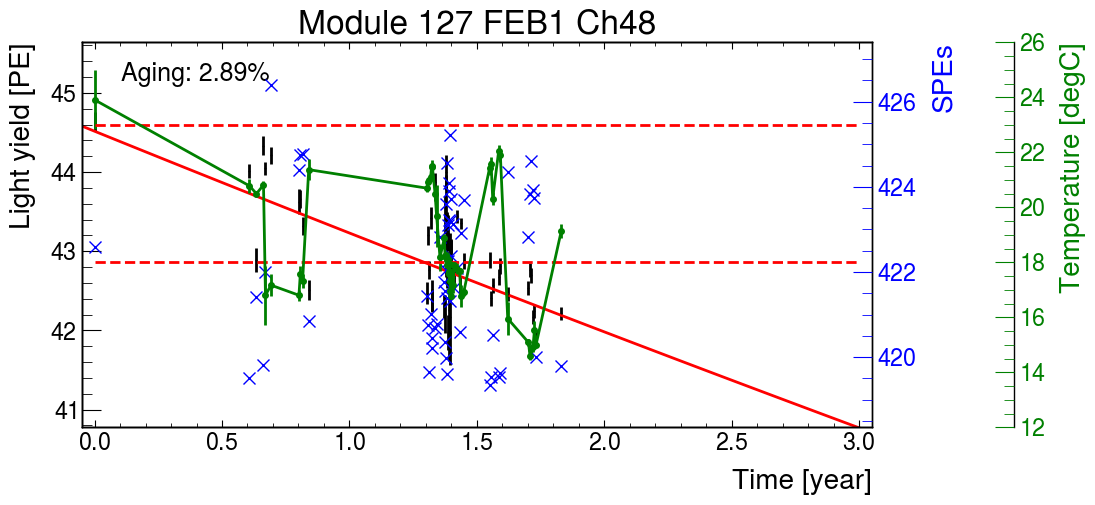

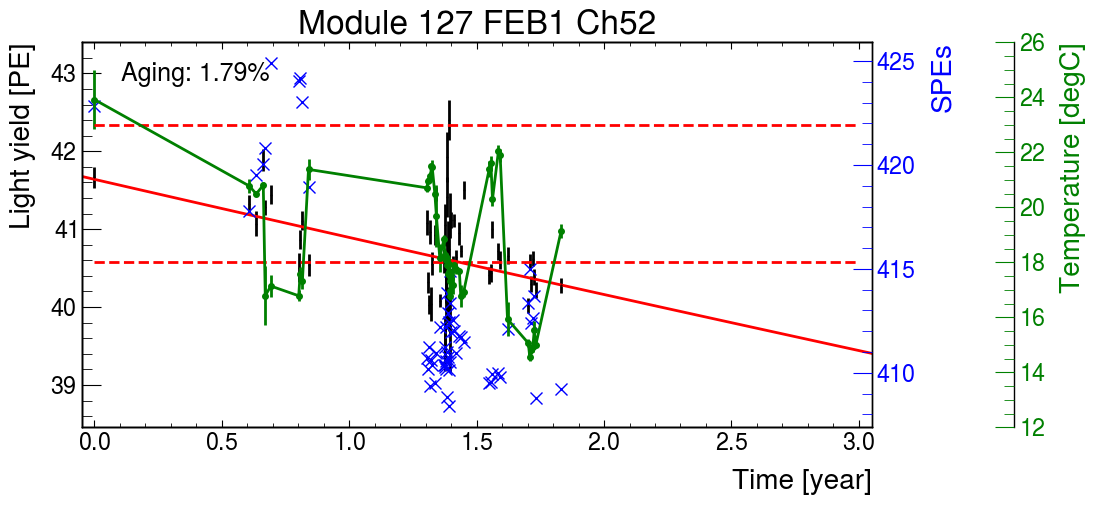

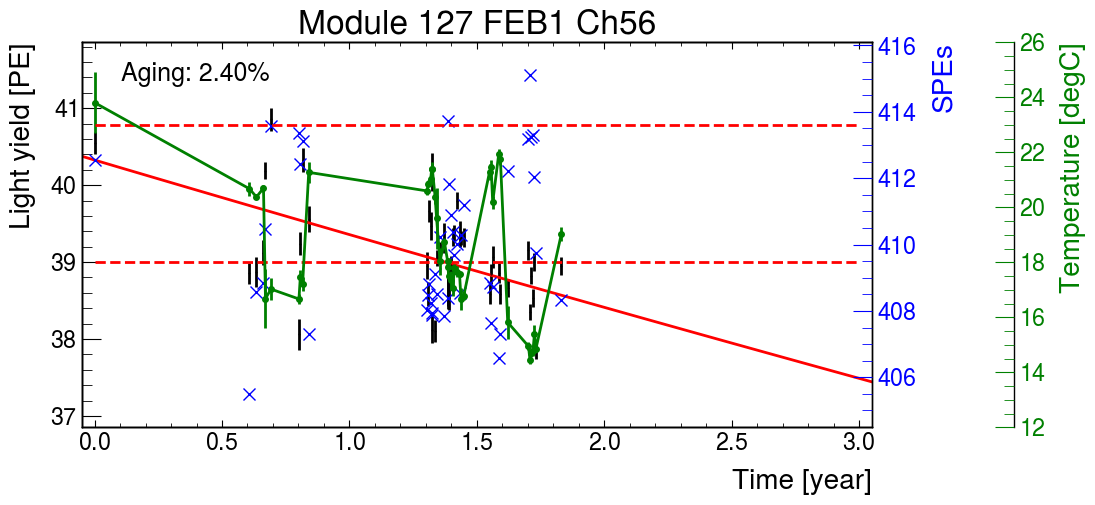

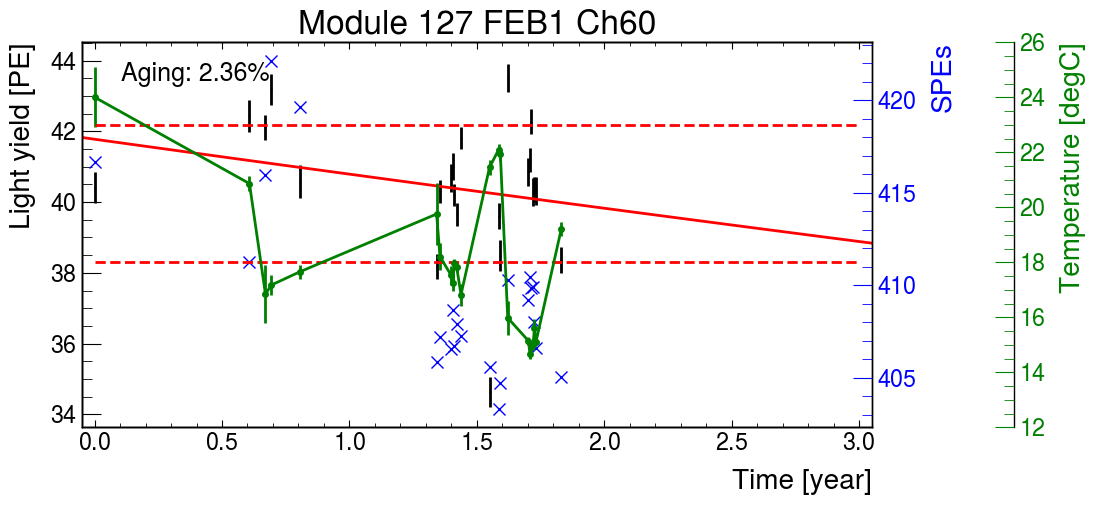

In [19]:
for chan in range(128):
    if chan in badchannels:
        continue
        
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["SPEs_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
    d["SPEs_binned_{0}".format(chan)] = binned_stats[0]
    d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2

    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
    d["PEs_binned_{0}".format(chan)] = binned_stats[0]
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_sigma_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
    d["PEs_sigma_binned_{0}".format(chan)] = binned_stats[0]
    
    valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]) | np.isnan(d["PEs_sigma_binned_{0}".format(chan)]))
    
    popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                           sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
    PE_aging.append(popt[1])
    if chan%4 == 0:
        fig, ax0 = plt.subplots()
        ax1 = ax0.twinx()
        ax2 = ax0.twinx()
        #ax1.plot(d['dt_binned_{0}'.format(chan)], d["SPEs_binned_{0}".format(chan)],'x', color='blue')
        ax1.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'x', color='blue')
        ax2.errorbar(d['dt_{0}'.format(chan)], d["temps_{0}".format(chan)],yerr=d["temps_sigma_{0}".format(chan)], fmt='.-', color='green')
        ax2.hlines(23, 0, 3, color='r', linestyle='--')
        ax2.hlines(18, 0, 3, color='r', linestyle='--')
        #ax0.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.083, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1, color='k')
        ax0.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)], yerr=d["PEs_sigma_{0}".format(chan)], fmt='.',markersize=1, color='k')
        ax0.plot(np.linspace(-0.1, 3.1, 100), aging(np.linspace(-0.1, 3.1, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')

        ax1.set_ylabel('SPEs', color='blue')
        ax0.set_ylabel('Light yield [PE]', color='k')
        ax2.set_ylabel('Temperature [degC]',color='green')
        ax0.set_title('Module 127 FEB{0} Ch{1}'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 3.05))
        ax1.set_xlim((-0.05, 3.05))

        ax1.set_ylim((min(d["SPEs_{0}".format(chan)]) - 1, max(d["SPEs_{0}".format(chan)]) + 1))
        ax0.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

        ax0.text(.05, .95, 'Aging: {0:.2f}%'.format(round(popt[1], 2)), fontsize=18, ha='left', va='top', transform=ax0.transAxes)
        
        ax1.tick_params(axis='y', which='both', colors='b')
        ax2.tick_params(axis='y', which='both', colors='g')
        ax2.spines['right'].set_position(("axes", 1.18))
        
        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        fig.show()

In [ ]:
for chan in range(128):
    if chan in lowaging:
        binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                              statistic='mean', bins=18, range=(0,3))
        d["PEs_binned_{0}".format(chan)] = binned_stats[0]
        d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2
        binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_sigma_{0}".format(chan)],
                                              statistic='mean', bins=18, range=(0,3))
        d["PEs_sigma_binned_{0}".format(chan)] = binned_stats[0]

        valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]) | np.isnan(d["PEs_sigma_binned_{0}".format(chan)]))

        popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                               sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
        
        fig, ax0 = plt.subplots()
        ax1 = ax0.twinx()
        ax2 = ax0.twinx()
        ax1.plot(d['dt_{0}'.format(chan)], d["SPEs_{0}".format(chan)],'x', color='blue')
        ax2.plot(d['dt_{0}'.format(chan)], d["temps_{0}".format(chan)],color='green')
        ax0.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)], yerr=d["PEs_sigma_{0}".format(chan)], fmt='.',markersize=1, color='k')
        ax0.plot(np.linspace(-0.1, 3.1, 100), aging(np.linspace(-0.1, 3.1, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')

        ax1.set_ylabel('SPEs [ADC*ns]', color='blue')
        ax0.set_ylabel('Light yield [PE]', color='k')
        ax2.set_ylabel('Temperature [degC]',color='green')
        ax0.set_title('Module 127 FEB{0} Ch{1}'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 3.05))
        ax1.set_xlim((-0.05, 3.05))

        ax1.set_ylim((min(d["SPEs_{0}".format(chan)]) - 1, max(d["SPEs_{0}".format(chan)]) + 1))
        ax0.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

        ax0.text(.05, .95, 'Aging: {0:.2f}%'.format(round(popt[1], 2)), fontsize=18, color='r', ha='left', va='top', transform=ax0.transAxes)
        
        ax1.tick_params(axis='y', which='both', colors='b')
        ax2.tick_params(axis='y', which='both', colors='g')
        ax2.spines['right'].set_position(("axes", 1.18))
        
        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        fig.show()

In [ ]:
for chan in range(128):
    if chan in highaging:
        binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["SPEs_{0}".format(chan)],
                                          statistic='mean', bins=18, range=(0,3))
        d["SPEs_binned_{0}".format(chan)] = binned_stats[0]
        d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2

        binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                              statistic='mean', bins=18, range=(0,3))
        d["PEs_binned_{0}".format(chan)] = binned_stats[0]
        binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_sigma_{0}".format(chan)],
                                              statistic='mean', bins=18, range=(0,3))
        d["PEs_sigma_binned_{0}".format(chan)] = binned_stats[0]

        valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]) | np.isnan(d["PEs_sigma_binned_{0}".format(chan)]))

        popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                               sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
        PE_aging.append(popt[1])
        
        fig, ax0 = plt.subplots()
        ax1 = ax0.twinx()
        ax2 = ax0.twinx()
        ax1.plot(d['dt_binned_{0}'.format(chan)], d["SPEs_binned_{0}".format(chan)],'.', color='blue')
        ax2.plot(d['dt_{0}'.format(chan)], d["temps_{0}".format(chan)],color='green')
        ax0.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.083, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1, color='k')
        ax0.plot(np.linspace(-0.1, 3.1, 100), aging(np.linspace(-0.1, 3.1, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')

        ax1.set_ylabel('SPEs', color='blue')
        ax0.set_ylabel('Light yield [PE]', color='k')
        ax2.set_ylabel('Temperature [degC]',color='green')
        ax0.set_title('Module 127 FEB{0} Ch{1}'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 3.05))
        ax1.set_xlim((-0.05, 3.05))

        ax1.set_ylim((min(d["SPEs_{0}".format(chan)]) - 1, max(d["SPEs_{0}".format(chan)]) + 1))
        ax0.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

        ax0.text(.05, .95, 'Aging: {0:.2f}%'.format(round(popt[1], 2)), fontsize=18, ha='left', va='top', transform=ax0.transAxes)
        
        ax1.tick_params(axis='y', which='both', colors='b')
        ax2.tick_params(axis='y', which='both', colors='g')
        ax2.spines['right'].set_position(("axes", 1.18))
        
        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        fig.show()

What if we only look at 2 years worth of aging data?

low aging 3
low aging 9
low aging 10
low aging 16
low aging 17
low aging 19
low aging 33
low aging 35
low aging 36
low aging 38
low aging 41
low aging 42
low aging 43
low aging 45
low aging 46
low aging 47
low aging 48
low aging 49
low aging 50
low aging 51
low aging 52
low aging 53
low aging 54


/tmp/ipykernel_13136/2377228883.py:2: RuntimeWarning: invalid value encountered in power
  return A*(1-r/100)**x


low aging 55
low aging 56
low aging 57
low aging 59
low aging 60
low aging 61
low aging 68
low aging 84
low aging 86
low aging 87
low aging 90
low aging 98
low aging 99


/tmp/ipykernel_13136/1357057737.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax0 = plt.subplots()


low aging 114
low aging 116
low aging 117
low aging 119
Is our aging distribution Gaussian?
Gaussian, ShapiroResult(statistic=0.9875656366348267, pvalue=0.3741925060749054)


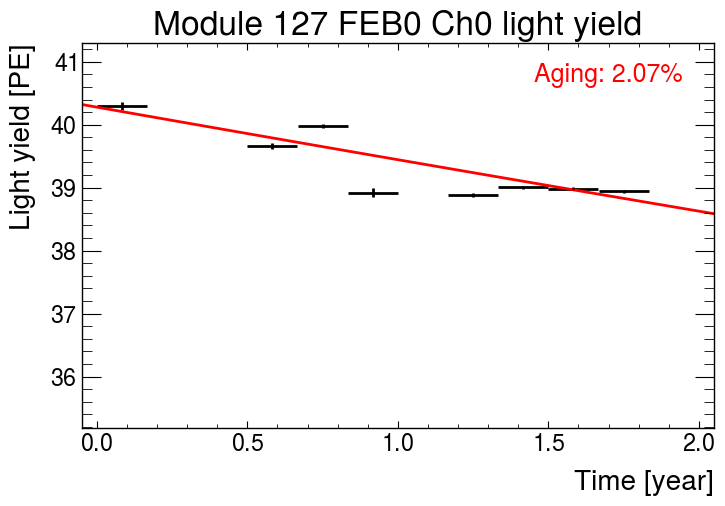

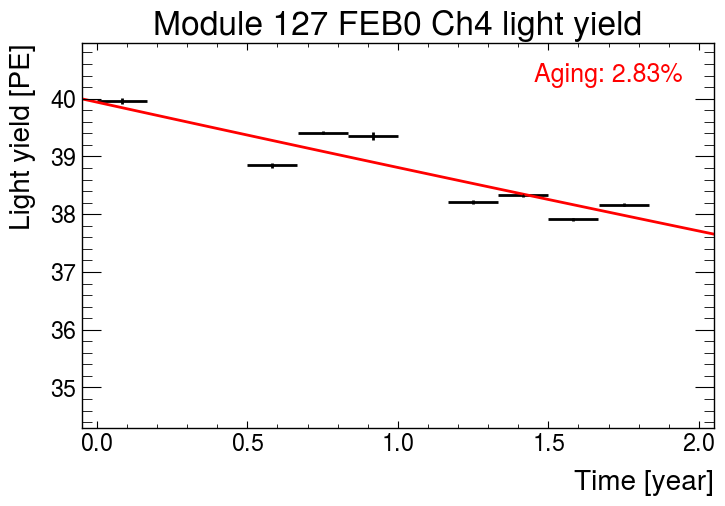

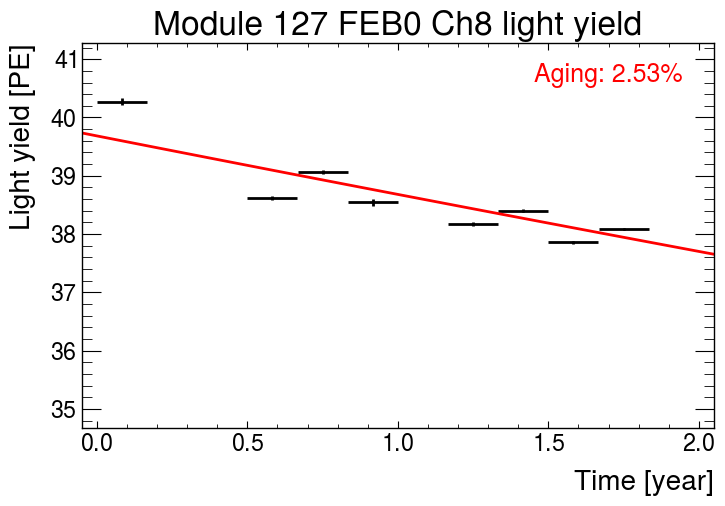

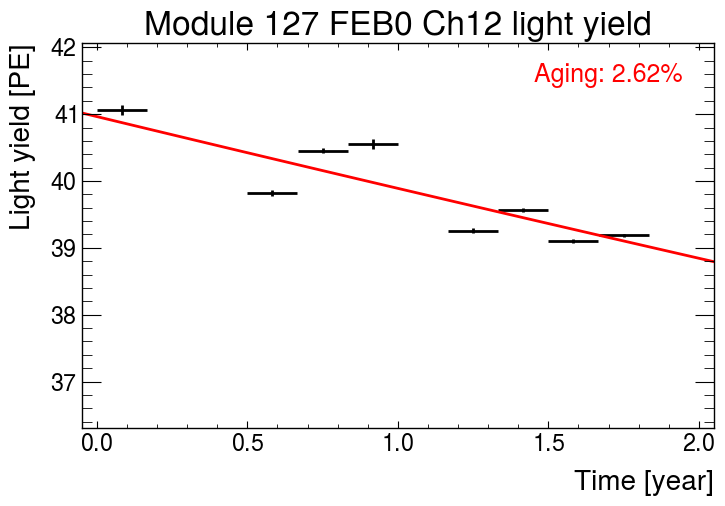

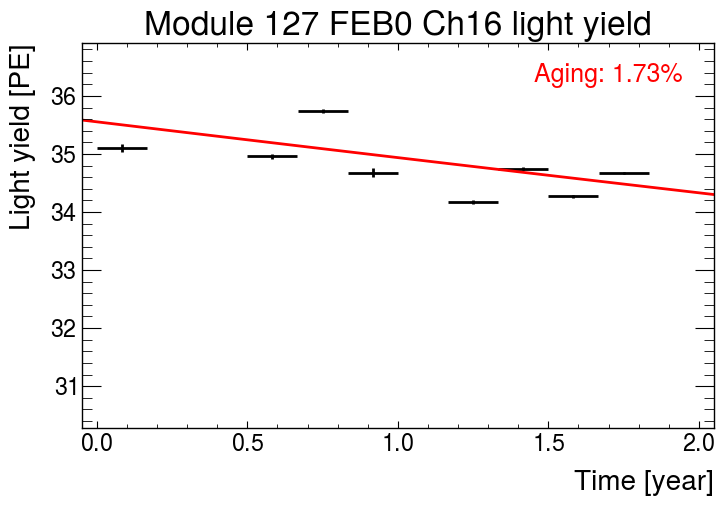

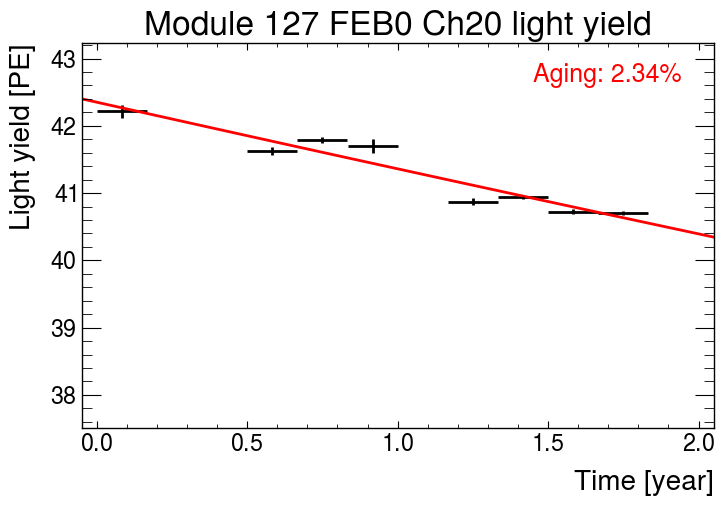

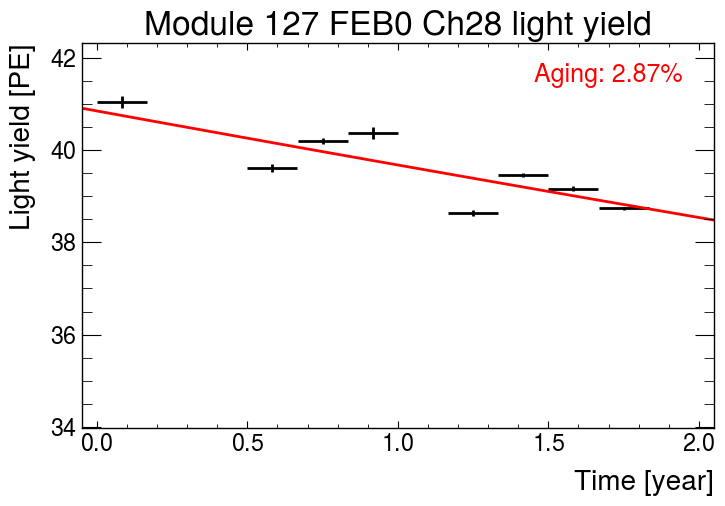

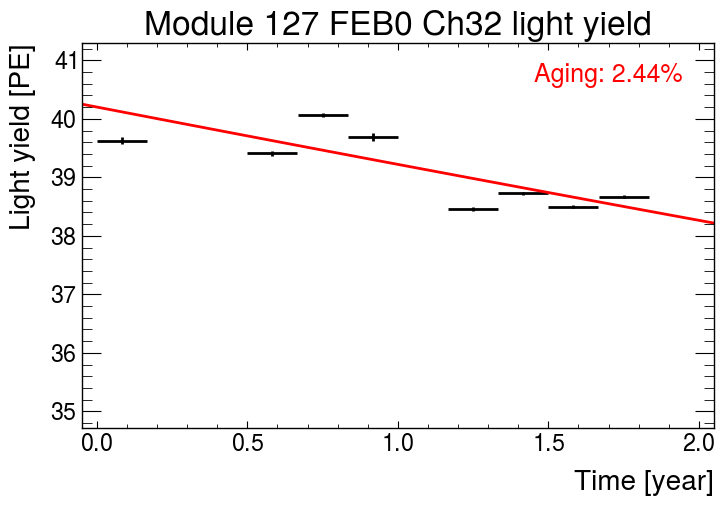

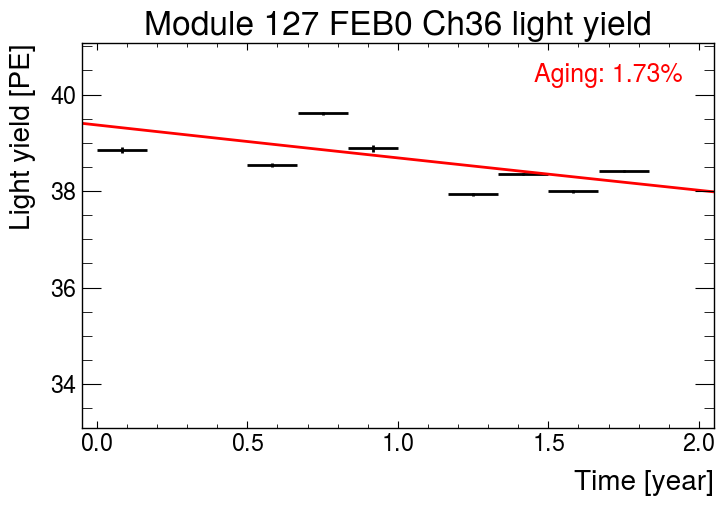

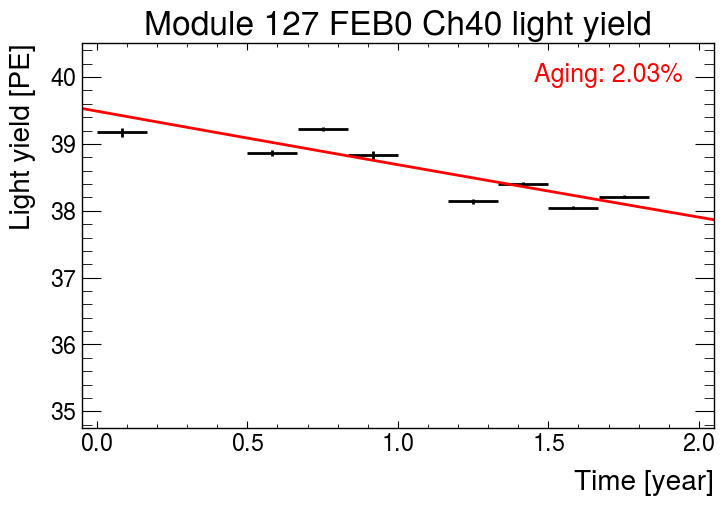

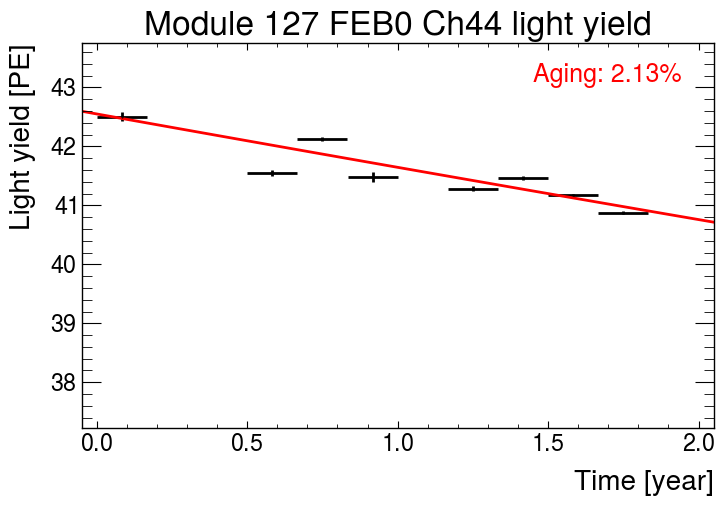

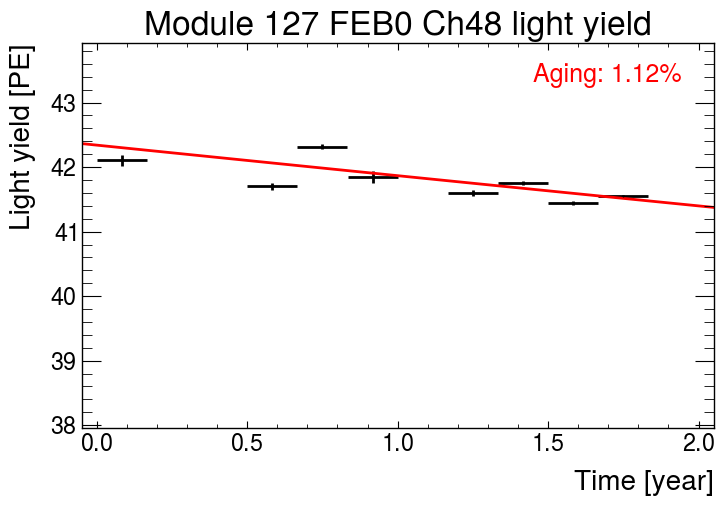

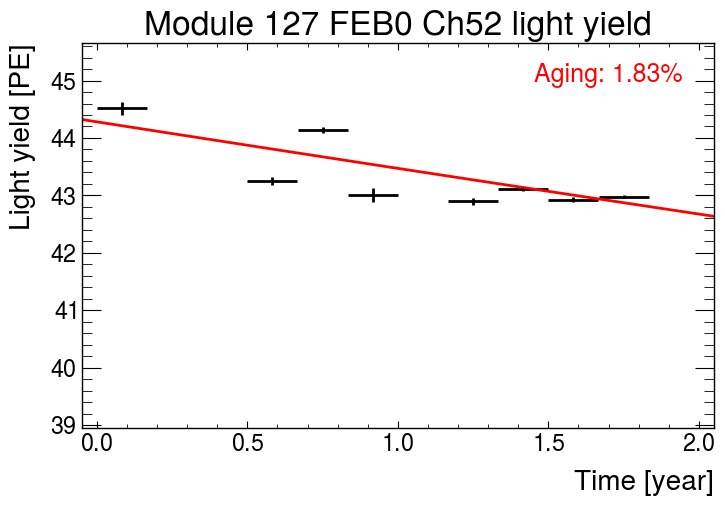

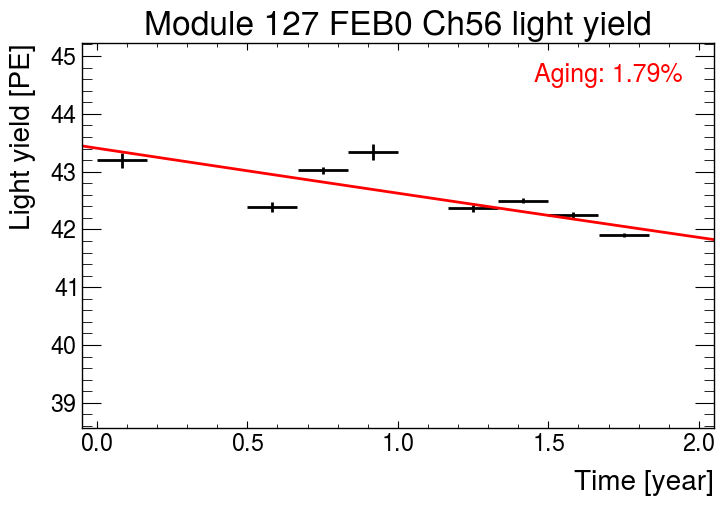

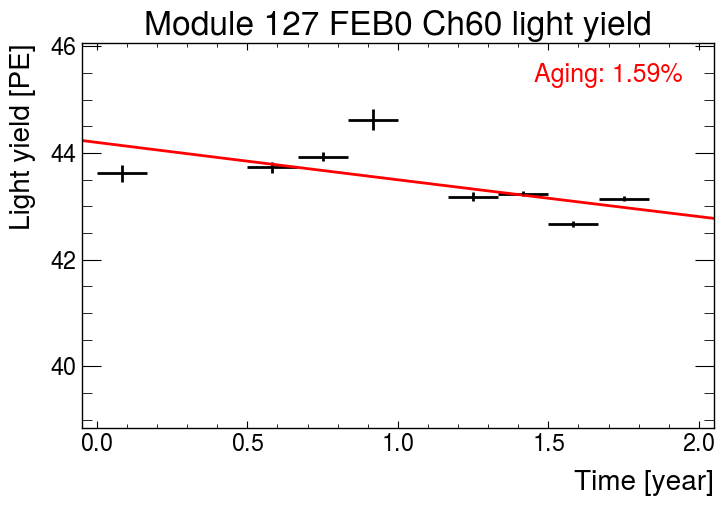

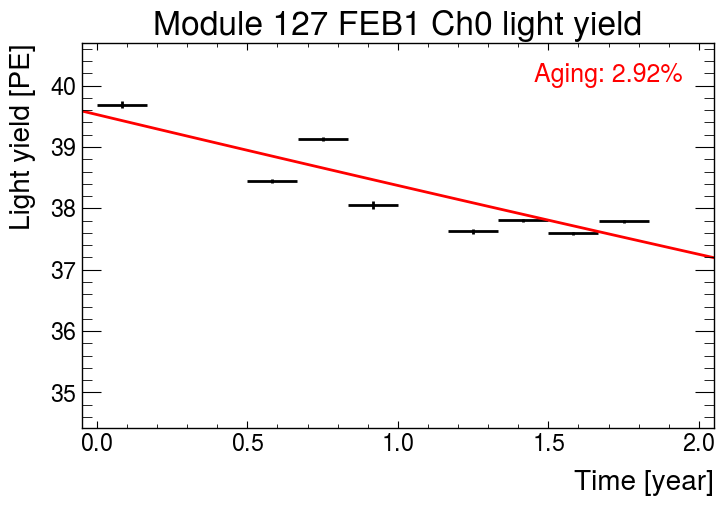

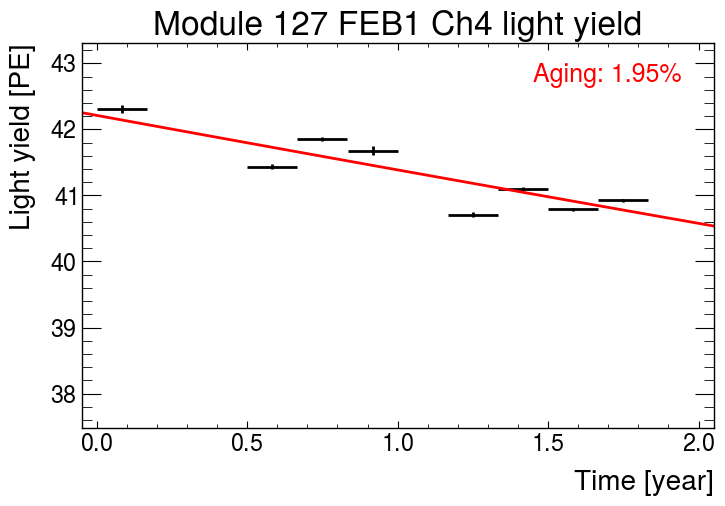

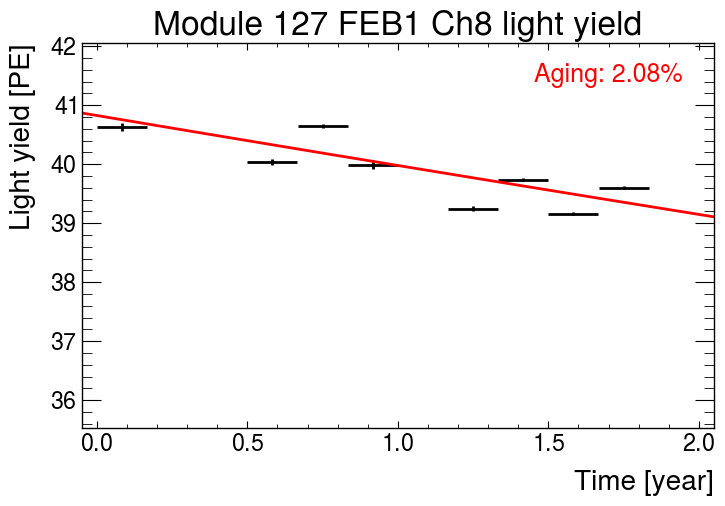

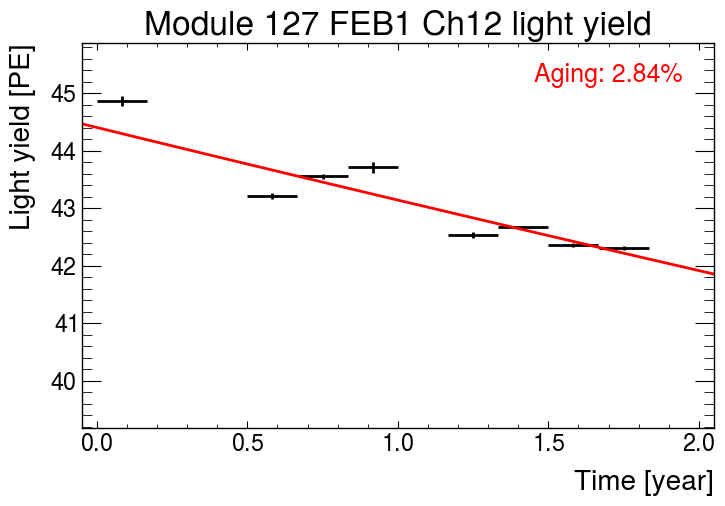

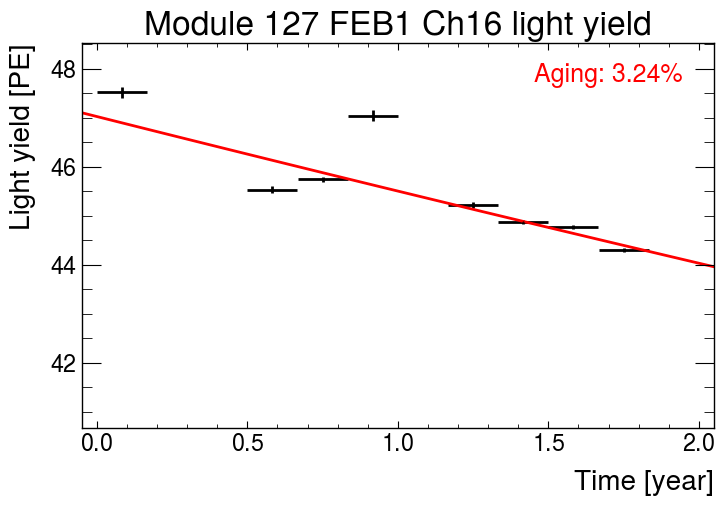

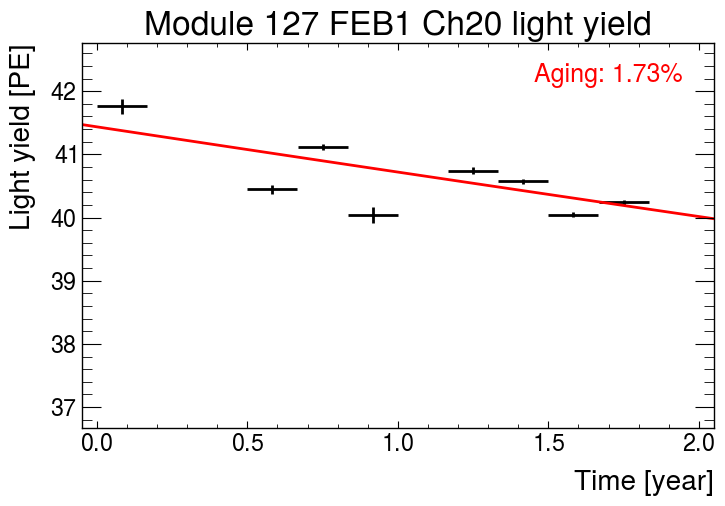

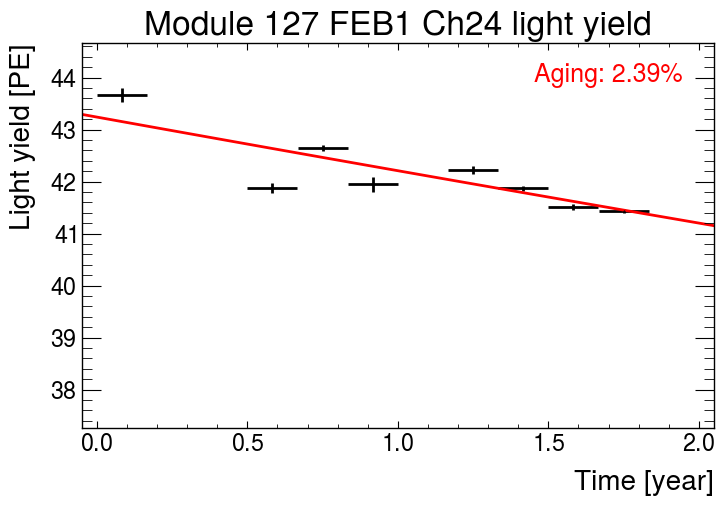

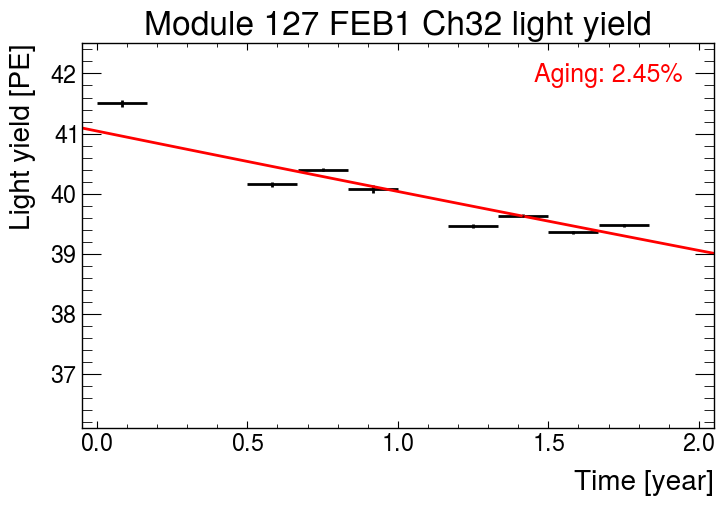

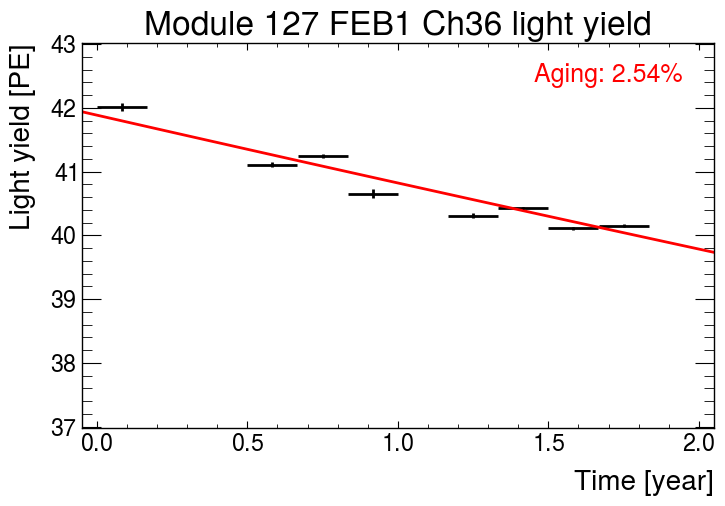

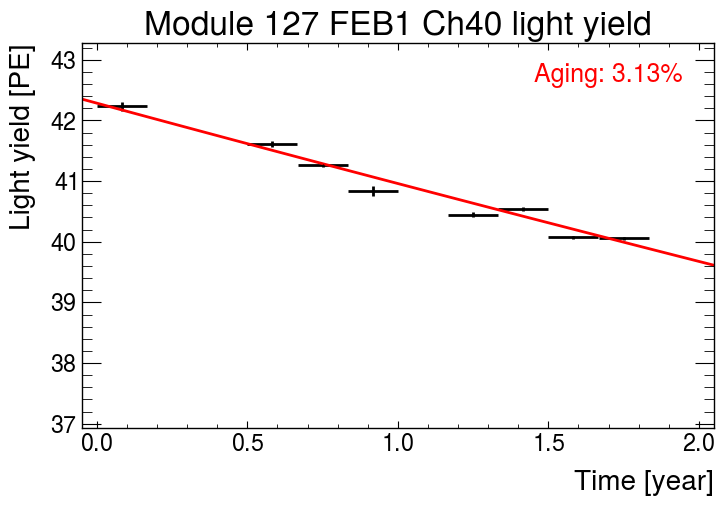

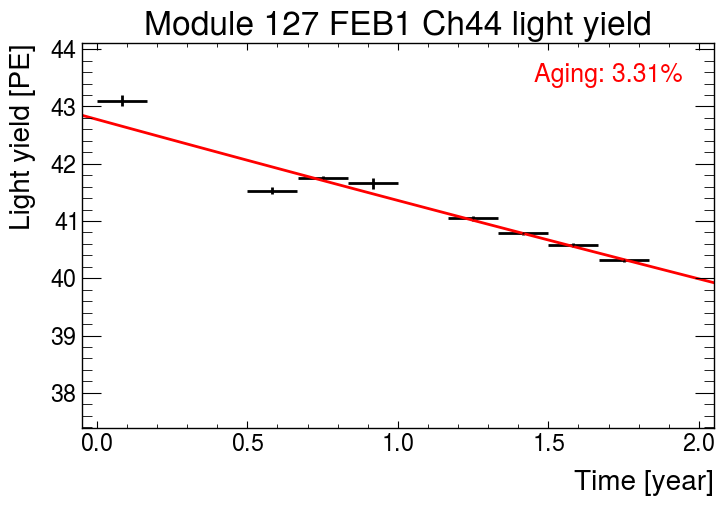

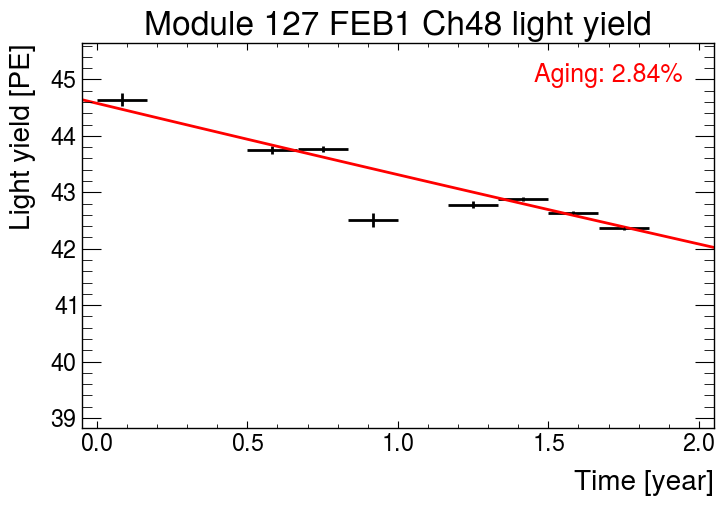

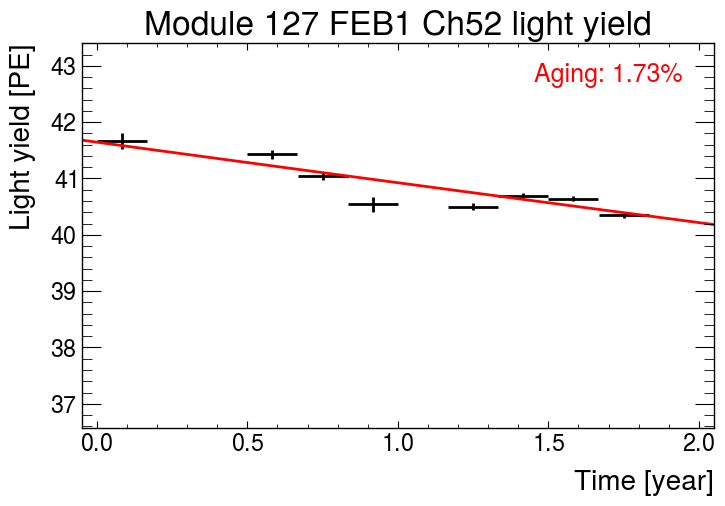

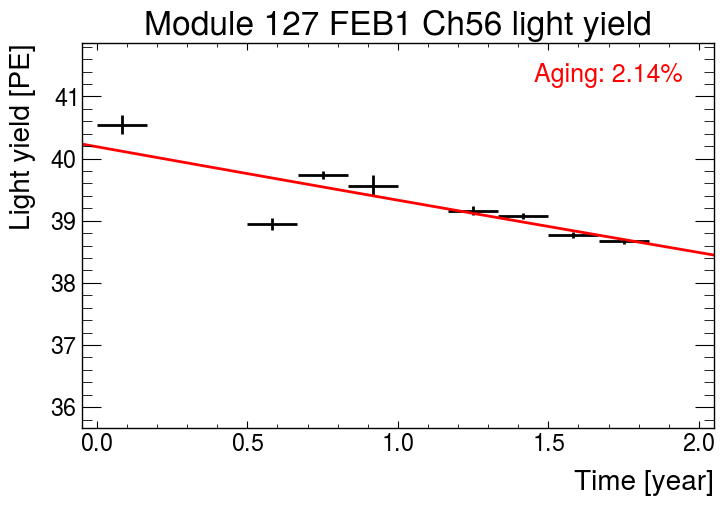

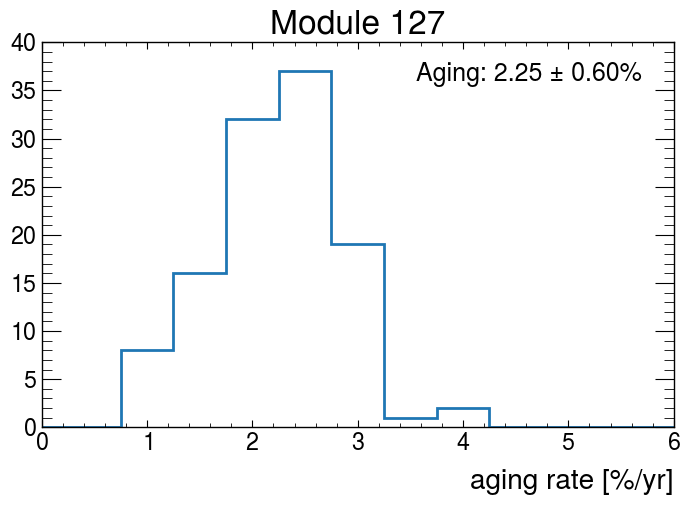

In [8]:
PE_aging = []
lowaging = []
highaging = []

for chan in range(128):
    if chan in badchannels:
        continue
        
    binned_stats = stats.binned_statistic(d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                                          statistic='mean', bins=12, range=(0,2))
    d["dt_binned_{0}".format(chan)] = (binned_stats[1][:-1] + binned_stats[1][1:])/2
    d["PEs_binned_{0}".format(chan)] = binned_stats[0]
    
    d["PEs_sigma_binned_{0}".format(chan)] = []
    for i in range(len(d["PEs_binned_{0}".format(chan)])):
        error = 0
        n = 0
        for j in range(len(d["PEs_sigma_{0}".format(chan)])):
            if d["dt_{0}".format(chan)][j] >= binned_stats[1][i] and d["dt_{0}".format(chan)][j] <= binned_stats[1][i+1]:
                error += (d["PEs_sigma_{0}".format(chan)][j])**2
                n += 1
        if n > 0:
            error = np.sqrt(error)/n
        d["PEs_sigma_binned_{0}".format(chan)].append(error)
    d["PEs_sigma_binned_{0}".format(chan)] = np.array(d["PEs_sigma_binned_{0}".format(chan)])
    
    valid = ~(np.isnan(d["PEs_binned_{0}".format(chan)]) | np.isnan(d["dt_binned_{0}".format(chan)]))
    
    popt, pcov = curve_fit(aging, d["dt_binned_{0}".format(chan)][valid], d["PEs_binned_{0}".format(chan)][valid],
                           sigma=d["PEs_sigma_binned_{0}".format(chan)][valid])
    #print(popt)
    PE_aging.append(popt[1])
    d["aging_{0}".format(chan)] = popt[1]
    d["initial_{0}".format(chan)] = popt[0]
    
    chi2 = 0
    for i in range(len(d["dt_binned_{0}".format(chan)][valid])):
        chi2 += ((d["PEs_binned_{0}".format(chan)][valid][i] - aging(d["dt_binned_{0}".format(chan)][valid][i], popt[0], popt[1]))/d["PEs_sigma_binned_{0}".format(chan)][valid][i])**2
    d["chi2_binned_{0}".format(chan)] = chi2
    d["chi2NDF_binned_{0}".format(chan)] = chi2/2

    if popt[1] < 2:
        print("low aging", chan)
        lowaging.append(chan)
    if popt[1] > 5:
        print("high aging", chan)
        highaging.append(chan)

    if chan%4 == 0:
        fig, ax0 = plt.subplots()
        ax0.errorbar(d['dt_binned_{0}'.format(chan)], d["PEs_binned_{0}".format(chan)], xerr=0.083, yerr=d["PEs_sigma_binned_{0}".format(chan)], fmt='.',markersize=1, color='k')
        ax0.plot(np.linspace(-0.1, 2.1, 100), aging(np.linspace(-0.1, 2.1, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')

        ax0.set_ylabel('Light yield [PE]')
        ax0.set_title('Module 127 FEB{0} Ch{1} light yield'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 2.05))

        ax0.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

        ax0.text(.95, .95, 'Aging: {0:.2f}%'.format(round(popt[1], 2)), fontsize=18, color='r', ha='right', va='top', transform=ax0.transAxes)
        #ax0.text(.95, .85, 'Chi2: {0:.2f}'.format(d["chi2_binned_{0}".format(chan)]), fontsize=18, ha='right', va='top', transform=ax0.transAxes)

        
        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(8)
        fig.show()

meanAging = np.mean(PE_aging)
stdAging = np.std(PE_aging)

print("Is our aging distribution Gaussian?")

if stats.shapiro(PE_aging)[1]<0.05:
    print("Not Gaussian,", stats.shapiro(PE_aging))
else:
    print("Gaussian,", stats.shapiro(PE_aging))
        
fig, ax0 = plt.subplots()
ax0.hist(PE_aging, bins = np.linspace(-0.75, 10.25, 23), histtype='step', linewidth=2)

ax0.set_title('Module 127')
ax0.set_xlabel('aging rate [%/yr]')

ax0.set_xlim((0,6))

ax0.text(.95, .95, 'Aging: {0:.2f} ± {1:.2f}%'.format(round(meanAging, 2), round(stdAging, 2)), fontsize=18, ha='right', va='top', transform=ax0.transAxes)

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.show()

low aging 2
low aging 3
low aging 8
low aging 10
low aging 22
low aging 27
low aging 28


/tmp/ipykernel_1931/2377228883.py:2: RuntimeWarning: invalid value encountered in power
  return A*(1-r/100)**x


low aging 41
low aging 43
low aging 44
low aging 45
low aging 46
low aging 47
low aging 48
low aging 49
low aging 50
low aging 51
low aging 53
low aging 54
low aging 55
low aging 56
low aging 57
low aging 59
low aging 61
low aging 62
low aging 63
low aging 68
low aging 69
low aging 70
low aging 71
low aging 75
low aging 79
low aging 83
low aging 84
low aging 85
low aging 86
low aging 87
low aging 88
low aging 89
low aging 90
high aging 95
low aging 99


/tmp/ipykernel_1931/2223846352.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax0 = plt.subplots()


low aging 116
low aging 117
low aging 120
high aging 124
low aging 126
high aging 127
Is our aging distribution Gaussian?
Not Gaussian, ShapiroResult(statistic=0.6770139932632446, pvalue=2.428126669455806e-15)


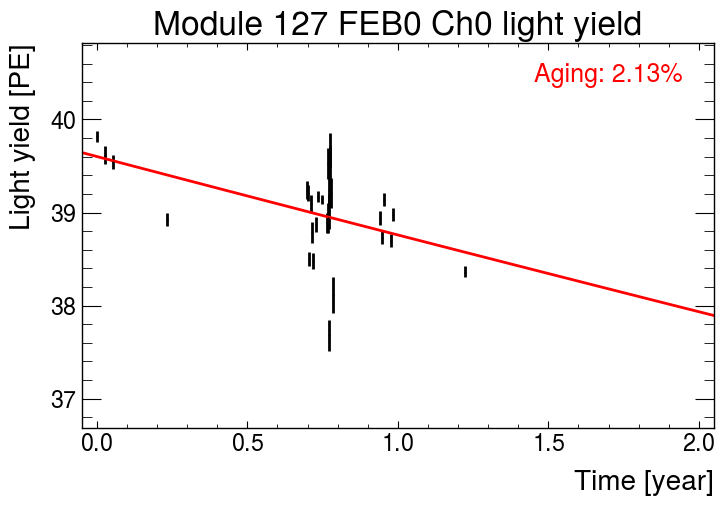

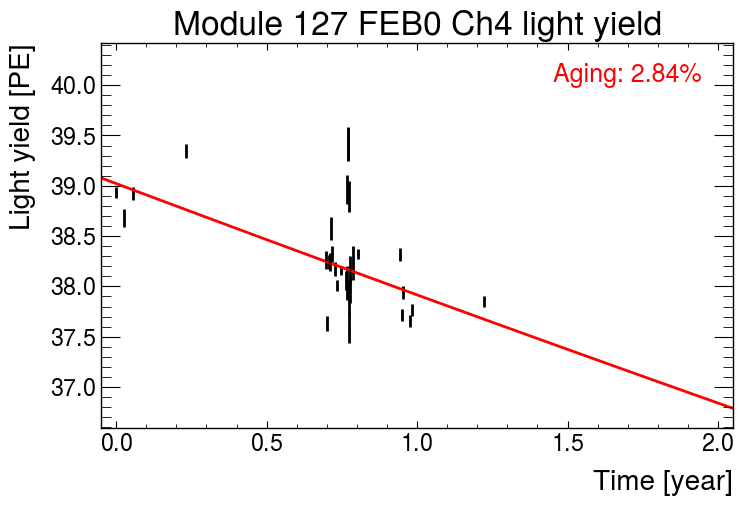

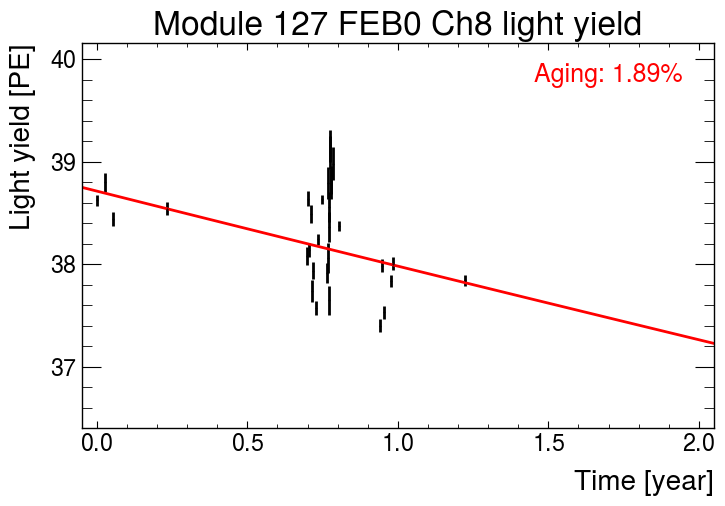

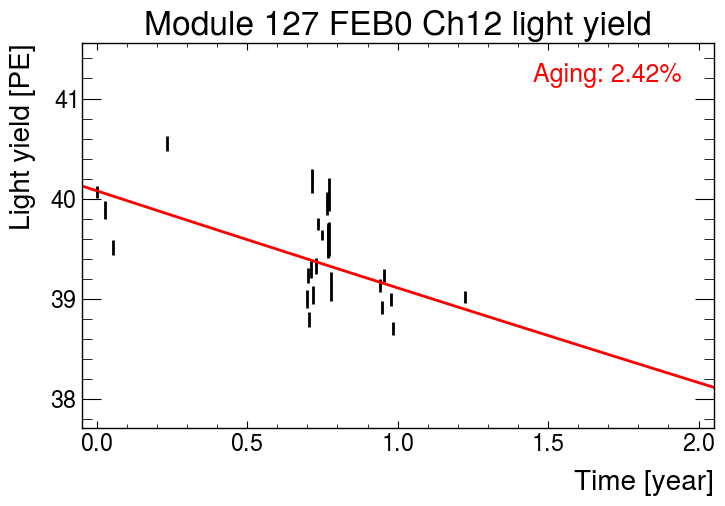

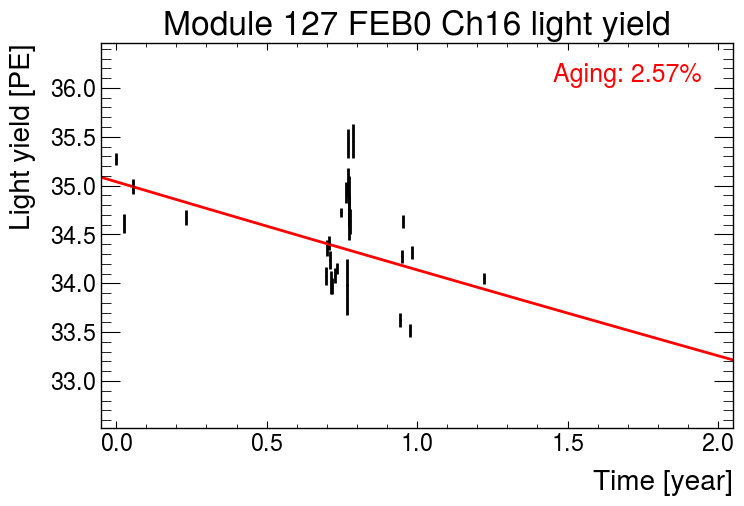

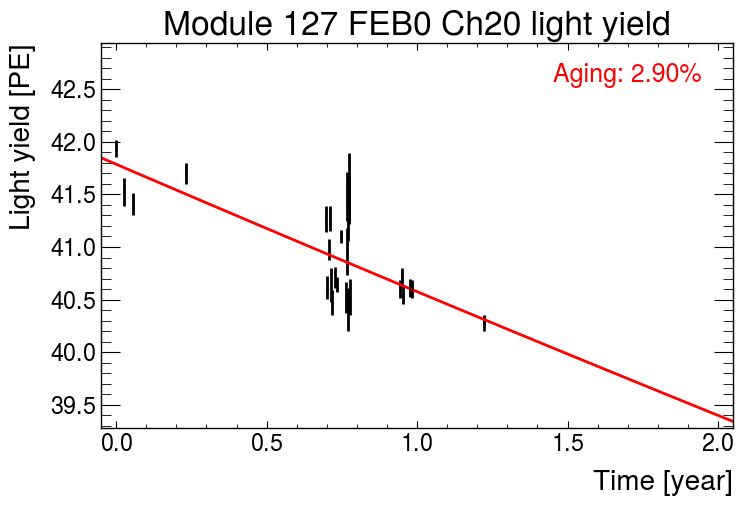

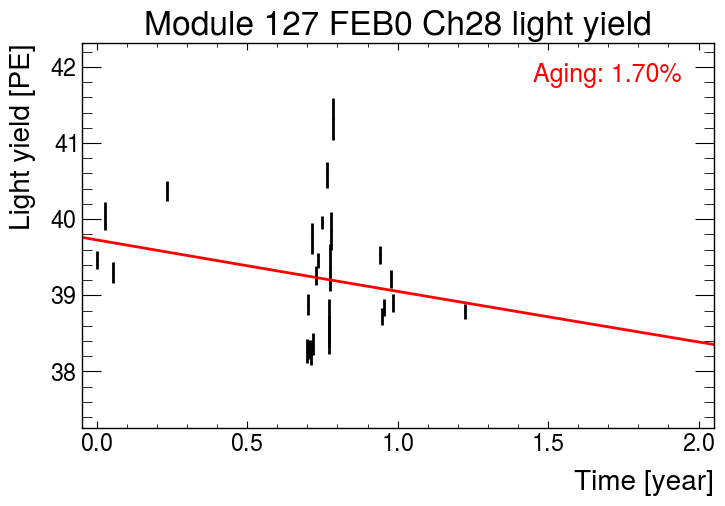

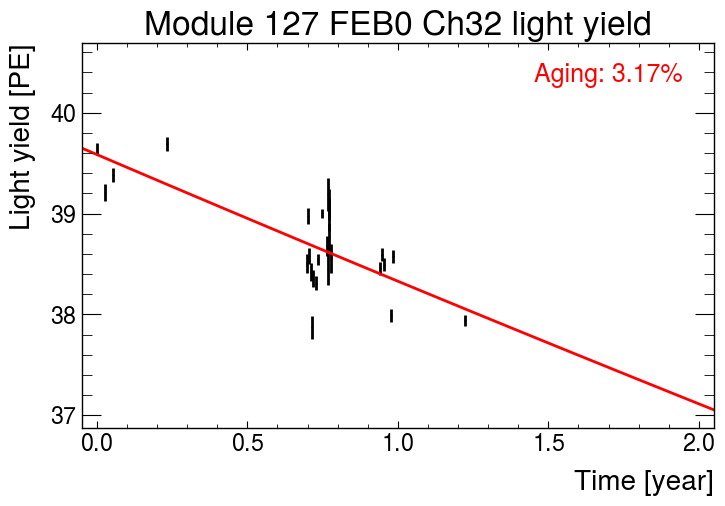

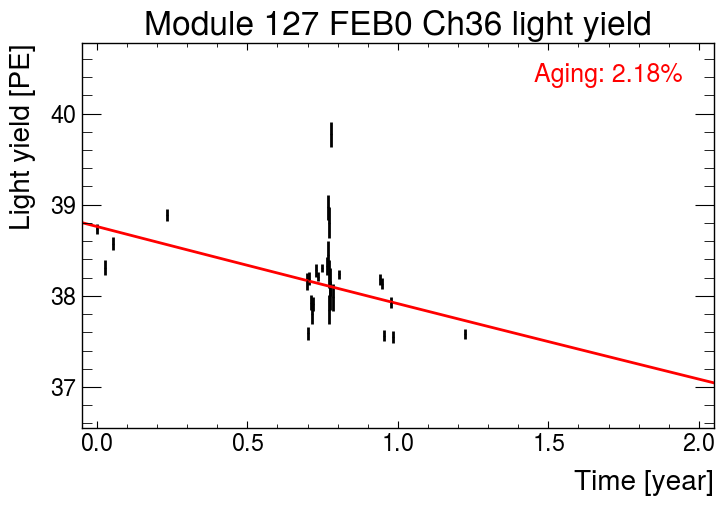

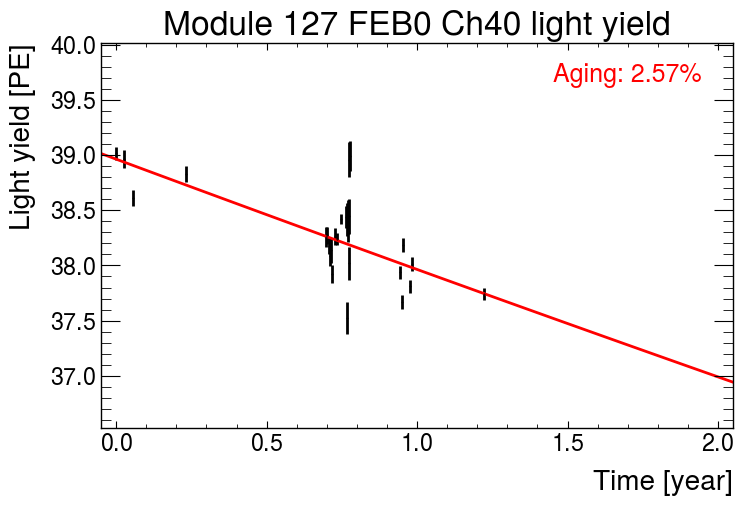

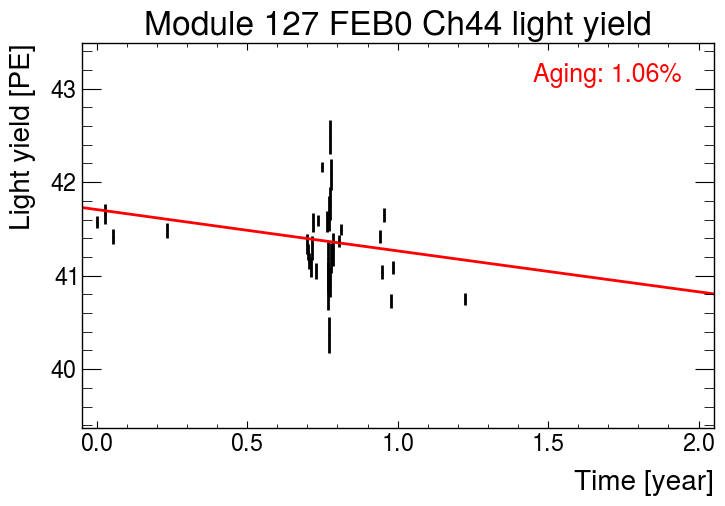

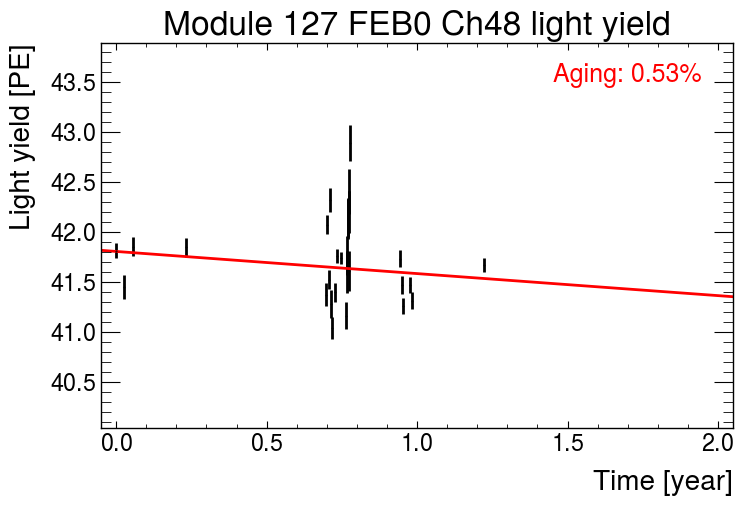

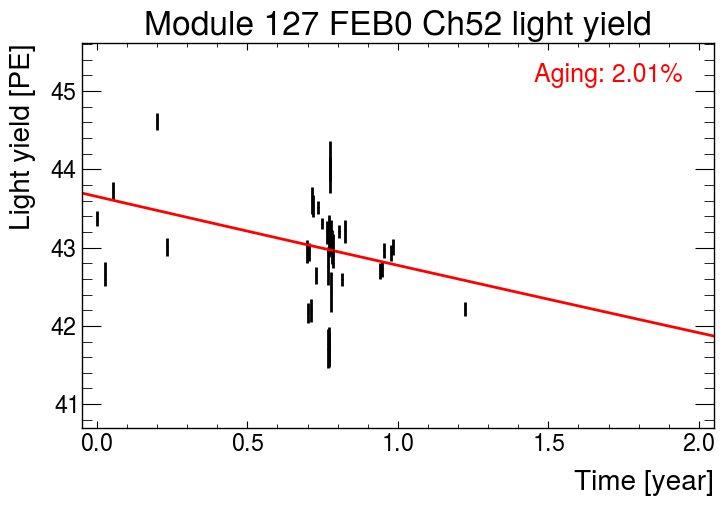

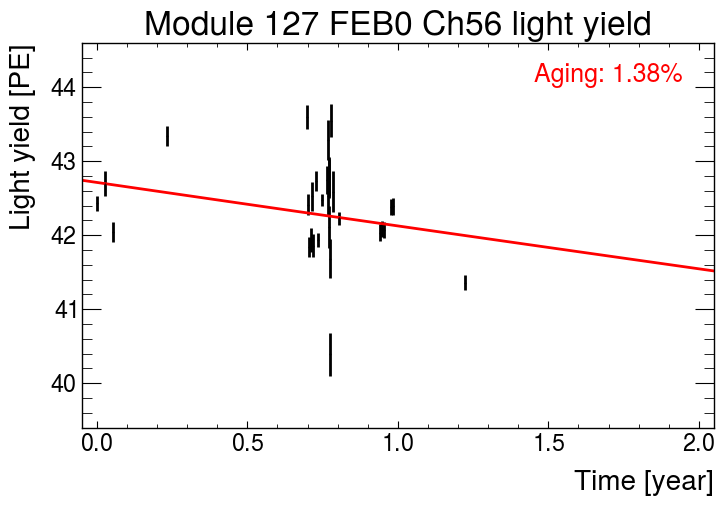

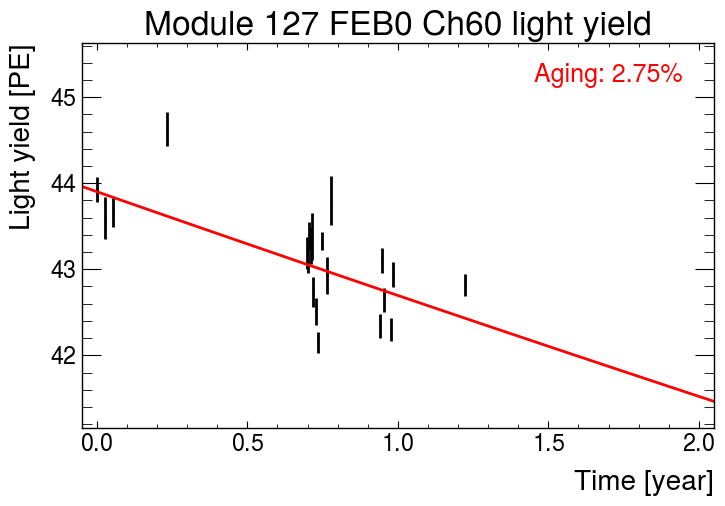

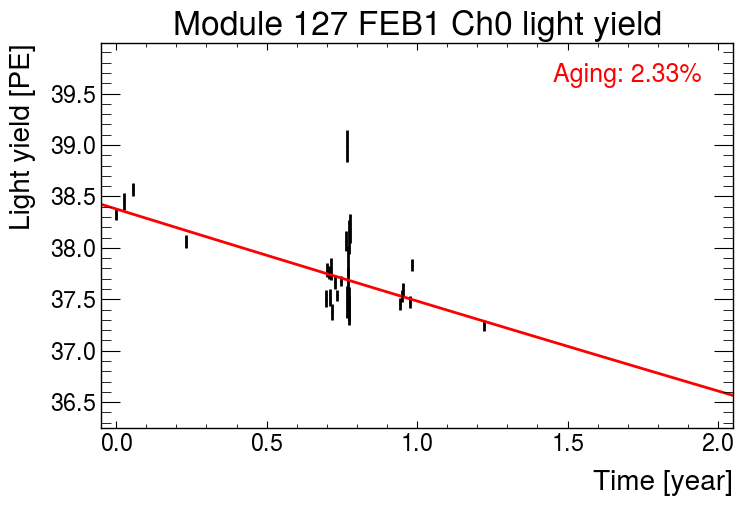

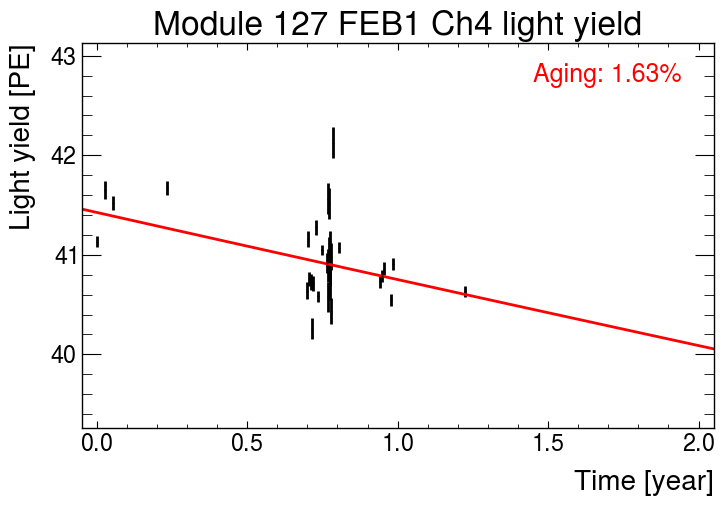

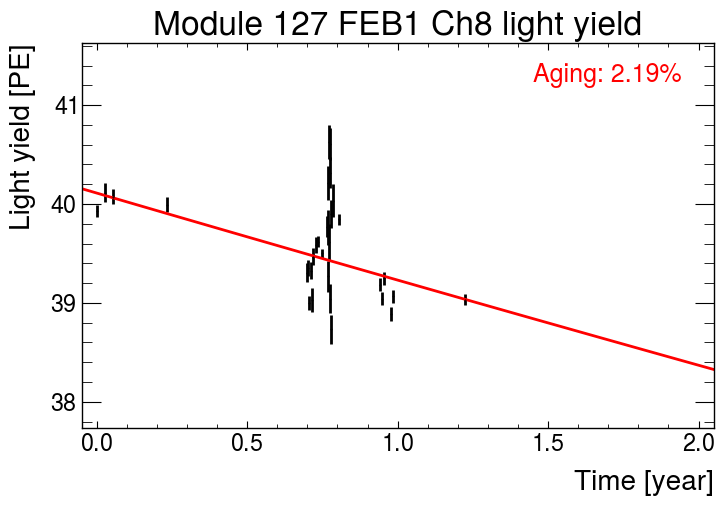

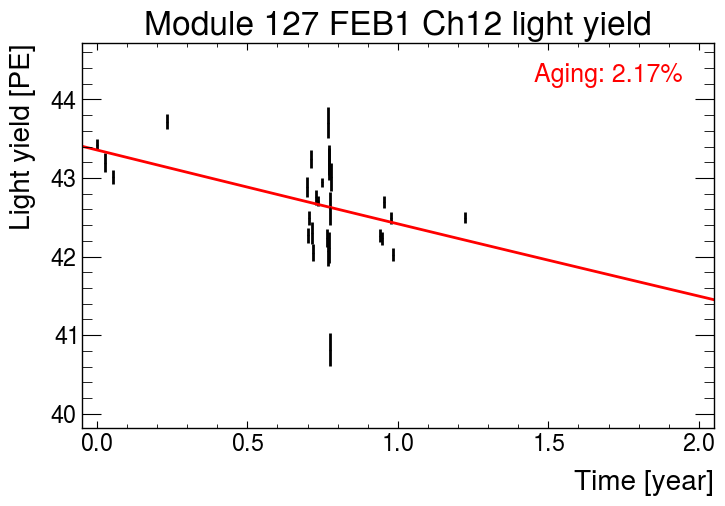

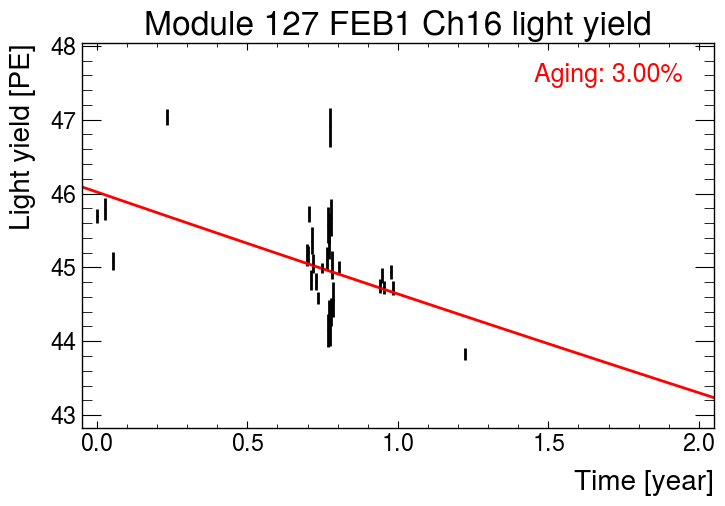

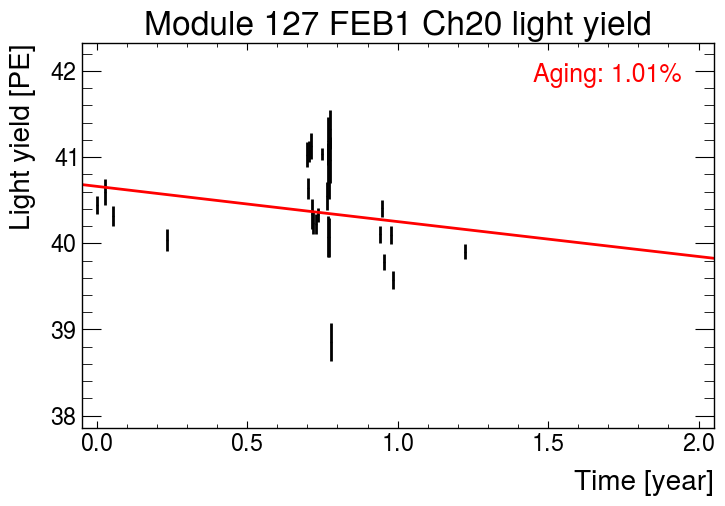

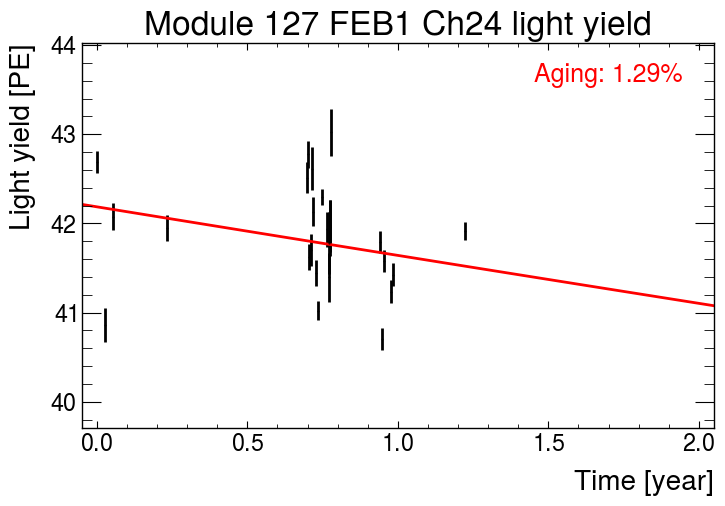

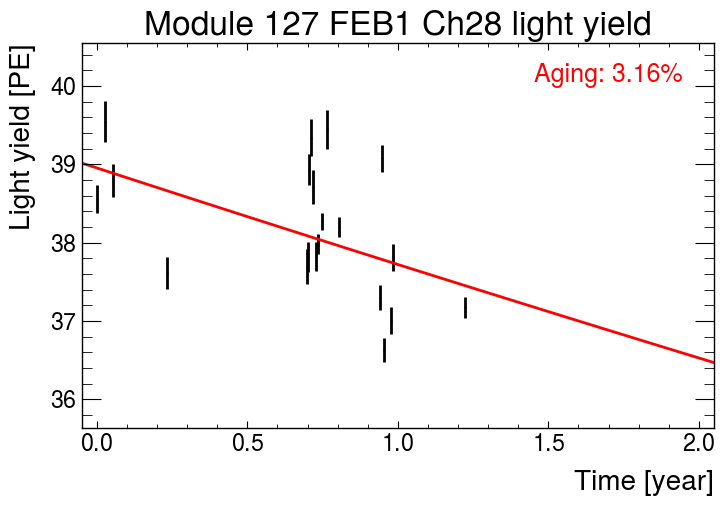

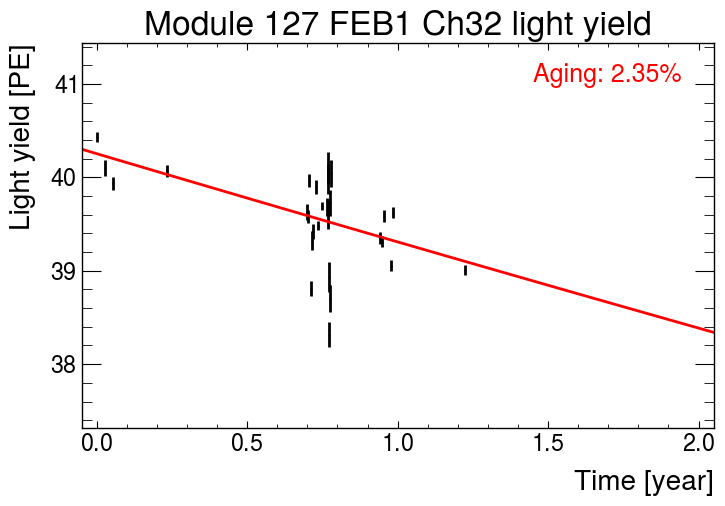

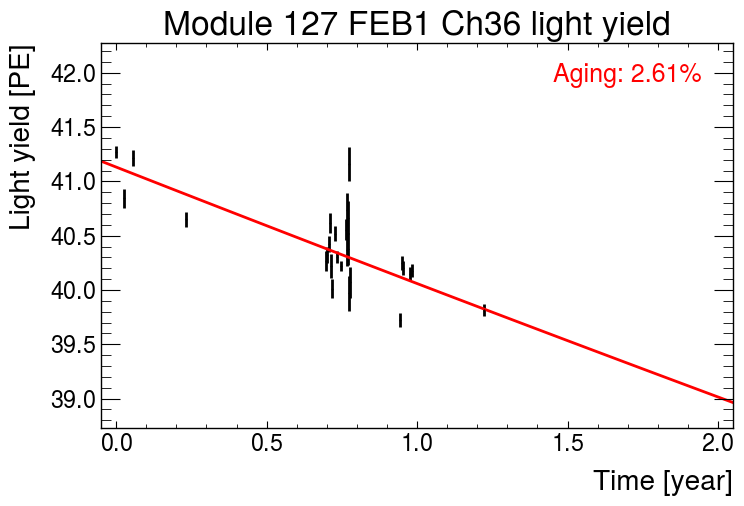

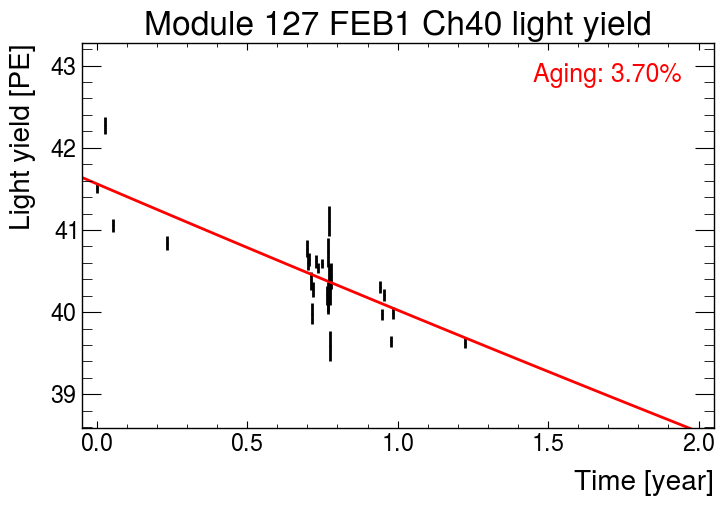

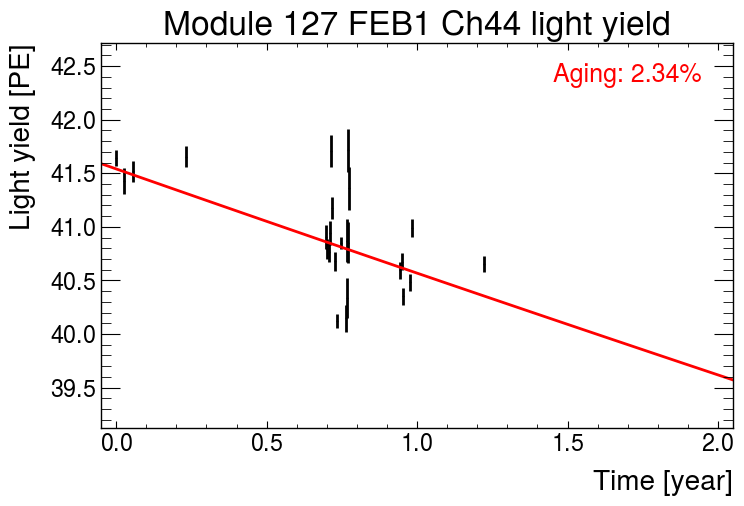

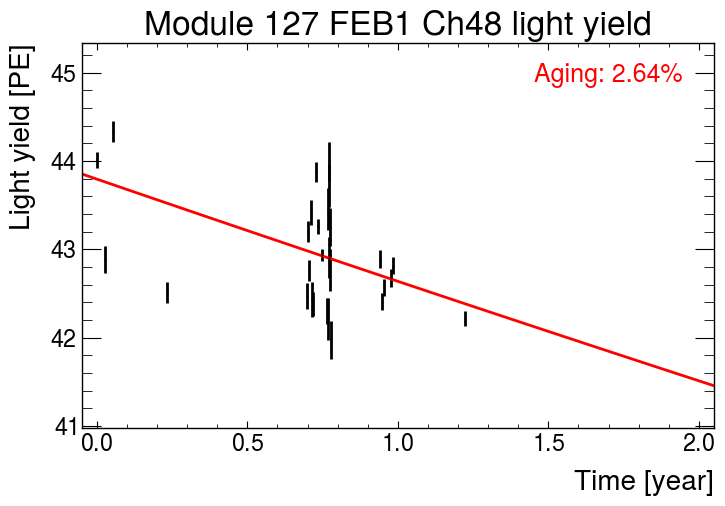

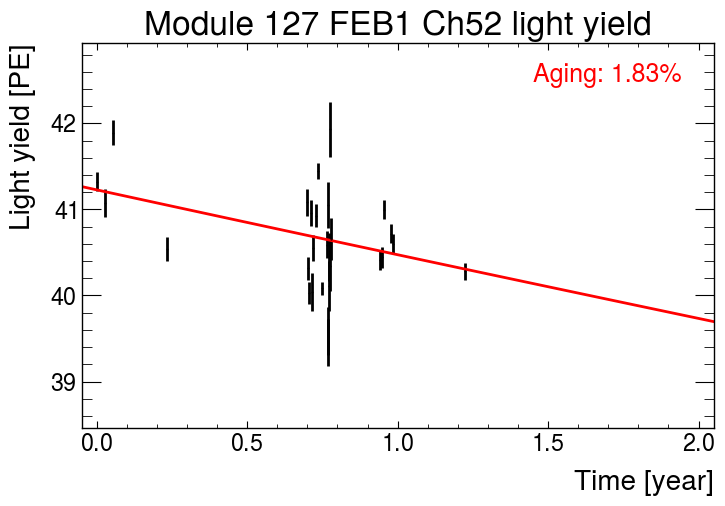

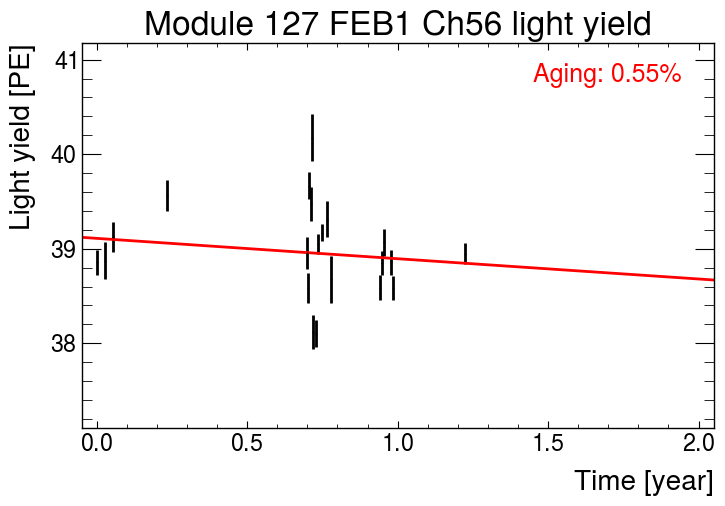

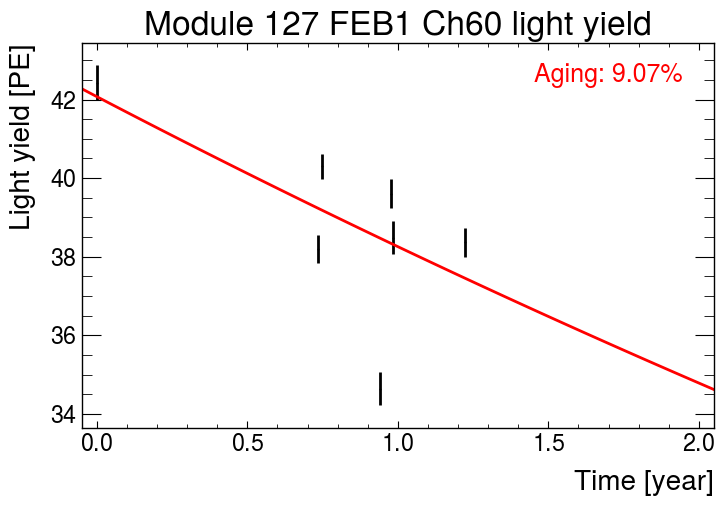

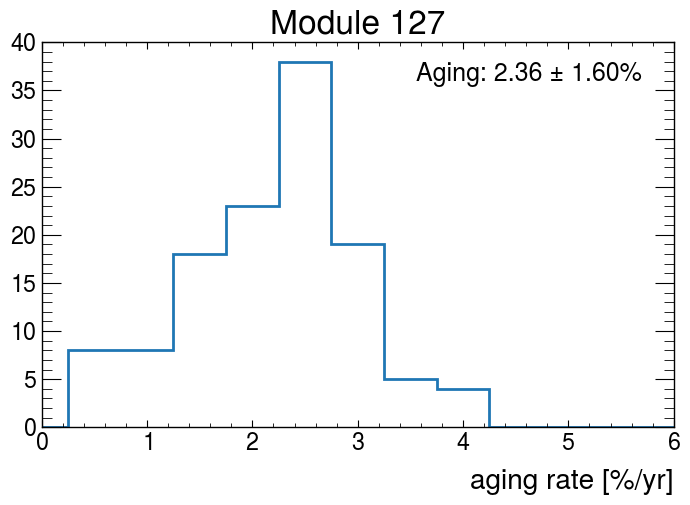

In [21]:
PE_aging = []
lowaging = []
highaging = []

for chan in range(128):
    if chan in badchannels:
        continue
    
    popt, pcov = curve_fit(aging, d["dt_{0}".format(chan)], d["PEs_{0}".format(chan)],
                           sigma=d["PEs_sigma_{0}".format(chan)])
    #print(popt)
    PE_aging.append(popt[1])
    d["aging_{0}".format(chan)] = popt[1]
    d["initial_{0}".format(chan)] = popt[0]
    
    chi2 = 0
    for i in range(len(d["dt_{0}".format(chan)])):
        chi2 += ((d["PEs_{0}".format(chan)][i] - aging(d["dt_{0}".format(chan)][i], popt[0], popt[1]))/d["PEs_sigma_{0}".format(chan)][i])**2
    d["chi2_{0}".format(chan)] = chi2
    d["chi2NDF_{0}".format(chan)] = chi2/2

    if popt[1] < 2:
        print("low aging", chan)
        lowaging.append(chan)
    if popt[1] > 5:
        print("high aging", chan)
        highaging.append(chan)

    if chan%4 == 0:
        fig, ax0 = plt.subplots()
        ax0.errorbar(d['dt_{0}'.format(chan)], d["PEs_{0}".format(chan)], yerr=d["PEs_sigma_{0}".format(chan)], fmt='.',markersize=1, color='k')
        ax0.plot(np.linspace(-0.1, 2.1, 100), aging(np.linspace(-0.1, 2.1, 100), popt[0], popt[1]), color='r')

        if chan < 64:
            FEB = 0
            channel = chan
        else:
            FEB = 1
            channel = chan - 64

        ax0.set_xlabel('Time [year]')

        ax0.set_ylabel('Light yield [PE]')
        ax0.set_title('Module 127 FEB{0} Ch{1} light yield'.format(int(FEB), int(channel)))

        ax0.set_xlim((-0.05, 2.05))

        ax0.set_ylim((min(d["PEs_{0}".format(chan)]) - 1, max(d["PEs_{0}".format(chan)]) + 1))

        ax0.text(.95, .95, 'Aging: {0:.2f}%'.format(round(popt[1], 2)), fontsize=18, color='r', ha='right', va='top', transform=ax0.transAxes)
        #ax0.text(.95, .85, 'Chi2: {0:.2f}'.format(d["chi2_binned_{0}".format(chan)]), fontsize=18, ha='right', va='top', transform=ax0.transAxes)

        
        fig.subplots_adjust(hspace=0)
        fig.set_figheight(5)
        fig.set_figwidth(8)
        fig.show()

meanAging = np.mean(PE_aging)
stdAging = np.std(PE_aging)

print("Is our aging distribution Gaussian?")

if stats.shapiro(PE_aging)[1]<0.05:
    print("Not Gaussian,", stats.shapiro(PE_aging))
else:
    print("Gaussian,", stats.shapiro(PE_aging))
        
fig, ax0 = plt.subplots()
ax0.hist(PE_aging, bins = np.linspace(-0.75, 10.25, 23), histtype='step', linewidth=2)

ax0.set_title('Module 127')
ax0.set_xlabel('aging rate [%/yr]')

ax0.set_xlim((0,6))

ax0.text(.95, .95, 'Aging: {0:.2f} ± {1:.2f}%'.format(round(meanAging, 2), round(stdAging, 2)), fontsize=18, ha='right', va='top', transform=ax0.transAxes)

fig.subplots_adjust(hspace=0)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.show()